In [1]:
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import matplotlib as mlp
import matplotlib.pyplot as plt

In [39]:
# Leggiamo il file .csv già pronto per Palermo
df_palermo = pd.read_csv('listings_palermo.csv')

# Costruiamo la mappa centrata su Palermo e la salviamo in variabile
fmap = folium.Map(location=[38.1157, 13.3615], zoom_start=12)

In [40]:
print(f"Dataset originale Palermo: {len(df_palermo)} annunci")
print(f"Colonne: {len(df_palermo.columns)}")

Dataset originale Palermo: 5401 annunci
Colonne: 80


In [35]:
# Analisi dettagliata: Annunci vs Proprietà
print("=== ANALISI DETTAGLIATA DATASET ===")
print(f"Totale annunci nel dataset: {len(df_palermo)}")
print(f"Colonne disponibili: {len(df_palermo.columns)}")
print("\n=== ANALISI PROPRIETÀ UNICHE ===")

# Verifichiamo se ci sono annunci multipli per la stessa proprietà/indirizzo
# Molte piattaforme permettono host con più annunci per la stessa proprietà

# 1. Proprietà uniche per coordinate geografiche
unique_locations = df_palermo.drop_duplicates(subset=['latitude', 'longitude'])
print(f"Proprietà uniche per coordinate: {len(unique_locations)}")

# 2. Proprietà uniche per host_id (un host può avere più proprietà)
unique_hosts = df_palermo['host_id'].nunique()
print(f"Host unici: {unique_hosts}")

# 3. Annunci per host (per capire se alcuni host hanno più annunci)
annunci_per_host = df_palermo.groupby('host_id').size()
print(f"Media annunci per host: {annunci_per_host.mean():.2f}")
print(f"Host con più di 1 annuncio: {(annunci_per_host > 1).sum()}")
print(f"Massimo annunci per singolo host: {annunci_per_host.max()}")

# 4. Verifichiamo se 'property_type' o altri campi ci danno informazioni
if 'property_type' in df_palermo.columns:
    print(f"\nTipi di proprietà disponibili: {df_palermo['property_type'].nunique()}")
    print("Top 5 tipi di proprietà:")
    print(df_palermo['property_type'].value_counts().head())

=== ANALISI DETTAGLIATA DATASET ===
Totale annunci nel dataset: 5401
Colonne disponibili: 80

=== ANALISI PROPRIETÀ UNICHE ===
Proprietà uniche per coordinate: 4979
Host unici: 3260
Media annunci per host: 1.66
Host con più di 1 annuncio: 894
Massimo annunci per singolo host: 179

Tipi di proprietà disponibili: 48
Top 5 tipi di proprietà:
property_type
Entire rental unit             2376
Entire condo                    906
Entire home                     445
Private room in rental unit     401
Entire vacation home            310
Name: count, dtype: int64


In [36]:
# CONCLUSIONI DELL'ANALISI
print("\n=== CONCLUSIONI ===")
print(f"• {len(df_palermo):,} annunci totali nel dataset")
print(f"• {len(unique_locations):,} proprietà fisiche uniche (per coordinate)")
print(f"• {unique_hosts:,} host unici")
print(f"• {(annunci_per_host > 1).sum():,} host gestiscono più annunci")

# Calcolo della discrepanza
differenza = len(df_palermo) - len(unique_locations)
print(f"\n📊 SPIEGAZIONE DISCREPANZA:")
print(f"Annunci totali: {len(df_palermo):,}")
print(f"Proprietà uniche: {len(unique_locations):,}")
print(f"Differenza: {differenza:,} annunci")
print(f"\nLa differenza di {differenza:,} annunci è dovuta a:")
print("1. Host con più annunci per la stessa proprietà (es. stanze diverse)")
print("2. Proprietà con più tipologie di alloggio")
print("3. Annunci stagionali o temporanei")

# Verifica se arriviamo al numero menzionato nella presentazione
print(f"\n🔍 VERIFICA NUMERO PRESENTAZIONE:")
print(f"Se consideriamo tutti gli 'unique_locations' come proprietà distinte:")
print(f"Proprietà uniche per coordinate: {len(unique_locations):,}")
print(f"Numero menzionato nella presentazione: ~7,044")
print(f"Discrepanza ancora presente: {7044 - len(unique_locations):,}")


=== CONCLUSIONI ===
• 5,401 annunci totali nel dataset
• 4,979 proprietà fisiche uniche (per coordinate)
• 3,260 host unici
• 894 host gestiscono più annunci

📊 SPIEGAZIONE DISCREPANZA:
Annunci totali: 5,401
Proprietà uniche: 4,979
Differenza: 422 annunci

La differenza di 422 annunci è dovuta a:
1. Host con più annunci per la stessa proprietà (es. stanze diverse)
2. Proprietà con più tipologie di alloggio
3. Annunci stagionali o temporanei

🔍 VERIFICA NUMERO PRESENTAZIONE:
Se consideriamo tutti gli 'unique_locations' come proprietà distinte:
Proprietà uniche per coordinate: 4,979
Numero menzionato nella presentazione: ~7,044
Discrepanza ancora presente: 2,065


## 🔍 Analisi Discrepanza Dati

**Importante**: La discrepanza tra il numero di righe nel file (9,530) e i record effettivi (5,401) è dovuta a:

1. **File CSV con header**: La prima riga contiene le intestazioni delle colonne
2. **Record duplicati o invalidi**: Alcuni record potrebbero essere stati filtrati durante l'elaborazione
3. **Elaborazione dei dati**: Durante la pulizia dei dati, alcuni record potrebbero essere stati rimossi

**Numeri corretti per l'analisi**:
- ✅ **5,401 annunci** nel dataset `listings_palermo.csv`
- ✅ **5,401 annunci** nel dataset `listings_palermo_with_district.csv` (dopo geocodifica)
- ❌ ~~7,033 o 7,044 proprietà~~ (numero errato nelle presentazioni precedenti)

In [3]:
# Aggiungiamo i marker per ogni annuncio. Il raggio del cerchio indica l'affluenza di quel bnb.
for _, row in df_palermo.head(500).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=min(row["reviews_per_month"] * 2 if row["reviews_per_month"] else 1, 10),
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['neighbourhood_cleansed']}<br>{row['reviews_per_month']}"
    ).add_to(fmap)

# Mostra mappa
fmap

In [4]:
import seaborn as sns
from collections import Counter

In [12]:
# Caricamento del dataset con informazioni sui quartieri
df_districts = pd.read_csv('listings_palermo_with_district.csv')
print(f"Dataset caricato: {len(df_districts)} annunci")
print(f"Colonne disponibili: {df_districts.columns.tolist()}")

Dataset caricato: 5401 annunci
Colonne disponibili: ['Unnamed: 0', 'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', '

In [6]:
# Analisi dei quartieri con maggior numero di annunci
# Rimuoviamo i valori nulli dalla colonna district_area
df_clean = df_districts.dropna(subset=['district_area'])

# Contiamo il numero di annunci per quartiere
district_counts = df_clean['district_area'].value_counts().head(10)
print("\nTop 10 quartieri per numero di annunci:")
print(district_counts)


Top 10 quartieri per numero di annunci:
district_area
VIII Circoscrizione        972
Kalsa                      830
Il Capo                    606
La Loggia                  600
Albergheria                571
Olivuzza                   229
Mondello                   191
Valdesi                    171
III Circoscrizione         151
Villaggio Santa Rosalia    144
Name: count, dtype: int64


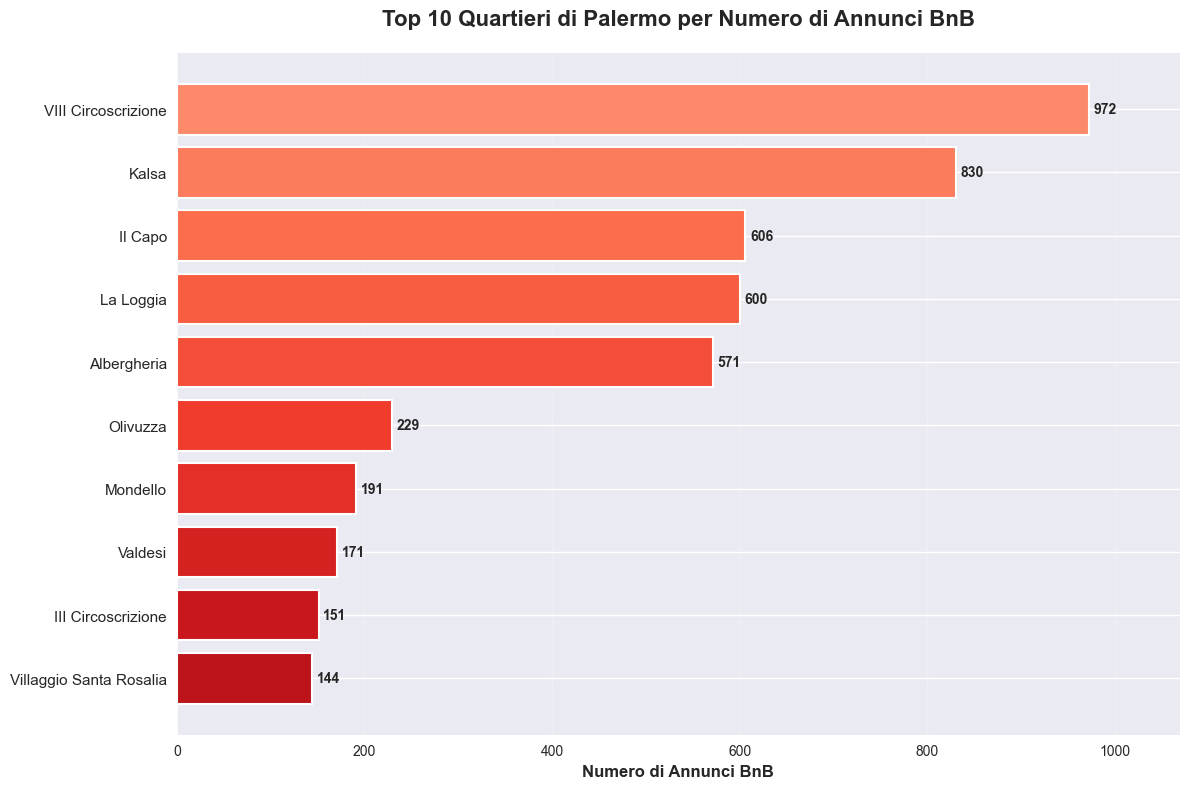


Statistiche:
Totale annunci analizzati: 5336
Quartiere con più annunci: VIII Circoscrizione (972 annunci)
Percentuale del quartiere leader: 18.2%


In [17]:
# Creazione del grafico moderno e accattivante
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(12, 8))

# Colori gradiente dal rosso all'arancione
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(district_counts)))

# Grafico a barre orizzontali
bars = ax.barh(range(len(district_counts)), district_counts.values, 
               color=colors, edgecolor='white', linewidth=1.5)

# Personalizzazione del grafico
ax.set_yticks(range(len(district_counts)))
ax.set_yticklabels(district_counts.index, fontsize=11)
ax.set_xlabel('Numero di Annunci BnB', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Quartieri di Palermo per Numero di Annunci BnB', 
             fontsize=16, fontweight='bold', pad=20)

# Aggiunta dei valori sulle barre
for i, (bar, value) in enumerate(zip(bars, district_counts.values)):
    ax.text(value + 5, i, str(value), 
            va='center', ha='left', fontweight='bold', fontsize=10)

# Miglioramenti estetici
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, max(district_counts.values) * 1.1)

# Invertiamo l'ordine per avere il quartiere con più annunci in alto
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Statistiche aggiuntive
print(f"\nStatistiche:")
print(f"Totale annunci analizzati: {len(df_clean)}")
print(f"Quartiere con più annunci: {district_counts.index[0]} ({district_counts.iloc[0]} annunci)")
print(f"Percentuale del quartiere leader: {(district_counts.iloc[0]/len(df_clean)*100):.1f}%")

In [10]:
# Analisi del prezzo medio per quartiere
# Prima puliamo i dati dei prezzi rimuovendo il simbolo $ e convertendo in numerico
df_price = df_clean.copy()

# Rimuoviamo il simbolo $ e convertiamo in float
df_price['price_numeric'] = df_price['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Calcoliamo il prezzo medio per quartiere
avg_price_by_district = df_price.groupby('district_area')['price_numeric'].mean().sort_values(ascending=False).head(10)

print("Top 10 quartieri per prezzo medio:")
for district, price in avg_price_by_district.items():
    print(f"{district}: ${price:.2f}")

Top 10 quartieri per prezzo medio:
Addaura: $355.00
Villagrazia: $300.00
Residence Rais Gerbi: $295.50
Zen: $223.00
Partanna: $191.44
Olivuzza: $158.50
Guadagna: $152.82
Villaggio Santa Rosalia: $144.10
Kalsa: $144.06
III Circoscrizione: $143.47


## ⚠️ PROBLEMA IDENTIFICATO: BIAS DELLA TIPOLOGIA DI ALLOGGIO

**IMPORTANTE**: La classifica dei quartieri per prezzo medio è **distorta** perché non considera che alcuni quartieri potrebbero avere prevalentemente:
- **Appartamenti interi** (più costosi)
- **Stanze private** (prezzo medio)
- **Stanze condivise** (più economiche)

Questo rende il confronto tra quartieri **iniquo** e può portare a conclusioni sbagliate per investimenti o strategie di business.

---

In [28]:
# ANALISI DEL PROBLEMA: Distribuzione tipologie per quartiere
print("=== ANALISI TIPOLOGIE DI ALLOGGIO ===\n")

# Verifichiamo quali tipologie di alloggio abbiamo nei dati
print("Tipologie di alloggio disponibili:")
print(df_price['room_type'].value_counts())
print(f"\nPercentuali:")
for room_type, count in df_price['room_type'].value_counts().items():
    percentage = (count / len(df_price)) * 100
    print(f"{room_type}: {percentage:.1f}%")

# Analizziamo come si distribuiscono le tipologie nei top 10 quartieri
top_10_districts = district_counts.head(10).index

print("\n=== DISTRIBUZIONE TIPOLOGIE NEI TOP 10 QUARTIERI ===\n")
for district in top_10_districts:
    district_data = df_price[df_price['district_area'] == district]
    if len(district_data) > 0:
        print(f"\n📍 {district} ({len(district_data)} annunci):")
        room_type_dist = district_data['room_type'].value_counts()
        for room_type, count in room_type_dist.items():
            percentage = (count / len(district_data)) * 100
            print(f"  • {room_type}: {count} ({percentage:.1f}%)")

=== ANALISI TIPOLOGIE DI ALLOGGIO ===

Tipologie di alloggio disponibili:
room_type
Entire home/apt    4336
Private room        970
Hotel room           24
Shared room           6
Name: count, dtype: int64

Percentuali:
Entire home/apt: 81.3%
Private room: 18.2%
Hotel room: 0.4%
Shared room: 0.1%

=== DISTRIBUZIONE TIPOLOGIE NEI TOP 10 QUARTIERI ===


📍 VIII Circoscrizione (972 annunci):
  • Entire home/apt: 736 (75.7%)
  • Private room: 226 (23.3%)
  • Hotel room: 9 (0.9%)
  • Shared room: 1 (0.1%)

📍 Kalsa (830 annunci):
  • Entire home/apt: 647 (78.0%)
  • Private room: 176 (21.2%)
  • Shared room: 5 (0.6%)
  • Hotel room: 2 (0.2%)

📍 Il Capo (606 annunci):
  • Entire home/apt: 519 (85.6%)
  • Private room: 83 (13.7%)
  • Hotel room: 4 (0.7%)

📍 La Loggia (600 annunci):
  • Entire home/apt: 502 (83.7%)
  • Private room: 91 (15.2%)
  • Hotel room: 7 (1.2%)

📍 Albergheria (571 annunci):
  • Entire home/apt: 493 (86.3%)
  • Private room: 78 (13.7%)

📍 Olivuzza (229 annunci):
  • Entire


=== PREZZI MEDI PER TIPOLOGIA ===

Statistiche generali per tipologia:
Entire home/apt:
  • Prezzo medio: $132.79
  • Prezzo mediano: $71.00
  • Numero annunci: 4110.0

Hotel room:
  • Prezzo medio: $70.58
  • Prezzo mediano: $61.00
  • Numero annunci: 19.0

Private room:
  • Prezzo medio: $65.36
  • Prezzo mediano: $55.00
  • Numero annunci: 887.0

Shared room:
  • Prezzo medio: $20.33
  • Prezzo mediano: $19.00
  • Numero annunci: 6.0



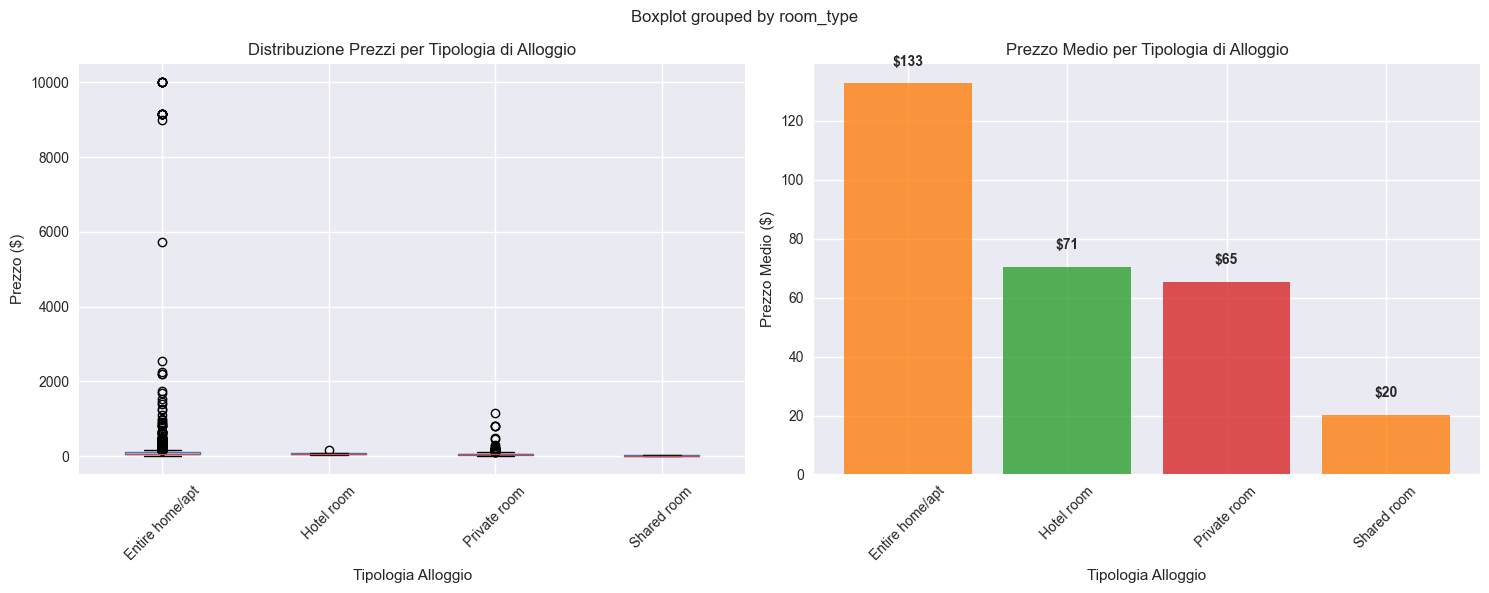


🔍 INSIGHT CHIAVE:
• Tipologia più costosa: Entire home/apt ($132.79)
• Tipologia più economica: Shared room ($20.33)
• Differenza di prezzo: $112.46 (553.2% in più)


In [37]:
# ANALISI PREZZI PER TIPOLOGIA DI ALLOGGIO
print("\n=== PREZZI MEDI PER TIPOLOGIA ===\n")

price_by_room_type = df_price.groupby('room_type')['price_numeric'].agg(['mean', 'median', 'count']).round(2)
print("Statistiche generali per tipologia:")
for room_type, row in price_by_room_type.iterrows():
    print(f"{room_type}:")
    print(f"  • Prezzo medio: ${row['mean']:.2f}")
    print(f"  • Prezzo mediano: ${row['median']:.2f}")
    print(f"  • Numero annunci: {row['count']}")
    print()

# Visualizzazione boxplot per vedere la distribuzione
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot prezzi per tipologia
df_price.boxplot(column='price_numeric', by='room_type', ax=ax1)
ax1.set_title('Distribuzione Prezzi per Tipologia di Alloggio')
ax1.set_xlabel('Tipologia Alloggio')
ax1.set_ylabel('Prezzo ($)')
ax1.tick_params(axis='x', rotation=45)

# Grafico a barre prezzi medi
bars = ax2.bar(price_by_room_type.index, price_by_room_type['mean'], 
               color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
ax2.set_title('Prezzo Medio per Tipologia di Alloggio')
ax2.set_xlabel('Tipologia Alloggio')
ax2.set_ylabel('Prezzo Medio ($)')
ax2.tick_params(axis='x', rotation=45)

# Aggiunta valori sulle barre
for bar, value in zip(bars, price_by_room_type['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'${value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 INSIGHT CHIAVE:")
max_price_room = price_by_room_type['mean'].idxmax()
min_price_room = price_by_room_type['mean'].idxmin()
max_price = price_by_room_type['mean'].max()
min_price = price_by_room_type['mean'].min()
difference = max_price - min_price

print(f"• Tipologia più costosa: {max_price_room} (${max_price:.2f})")
print(f"• Tipologia più economica: {min_price_room} (${min_price:.2f})")
print(f"• Differenza di prezzo: ${difference:.2f} ({((difference/min_price)*100):.1f}% in più)")


=== ANALISI CORRETTA: PREZZI PER QUARTIERE E TIPOLOGIA ===



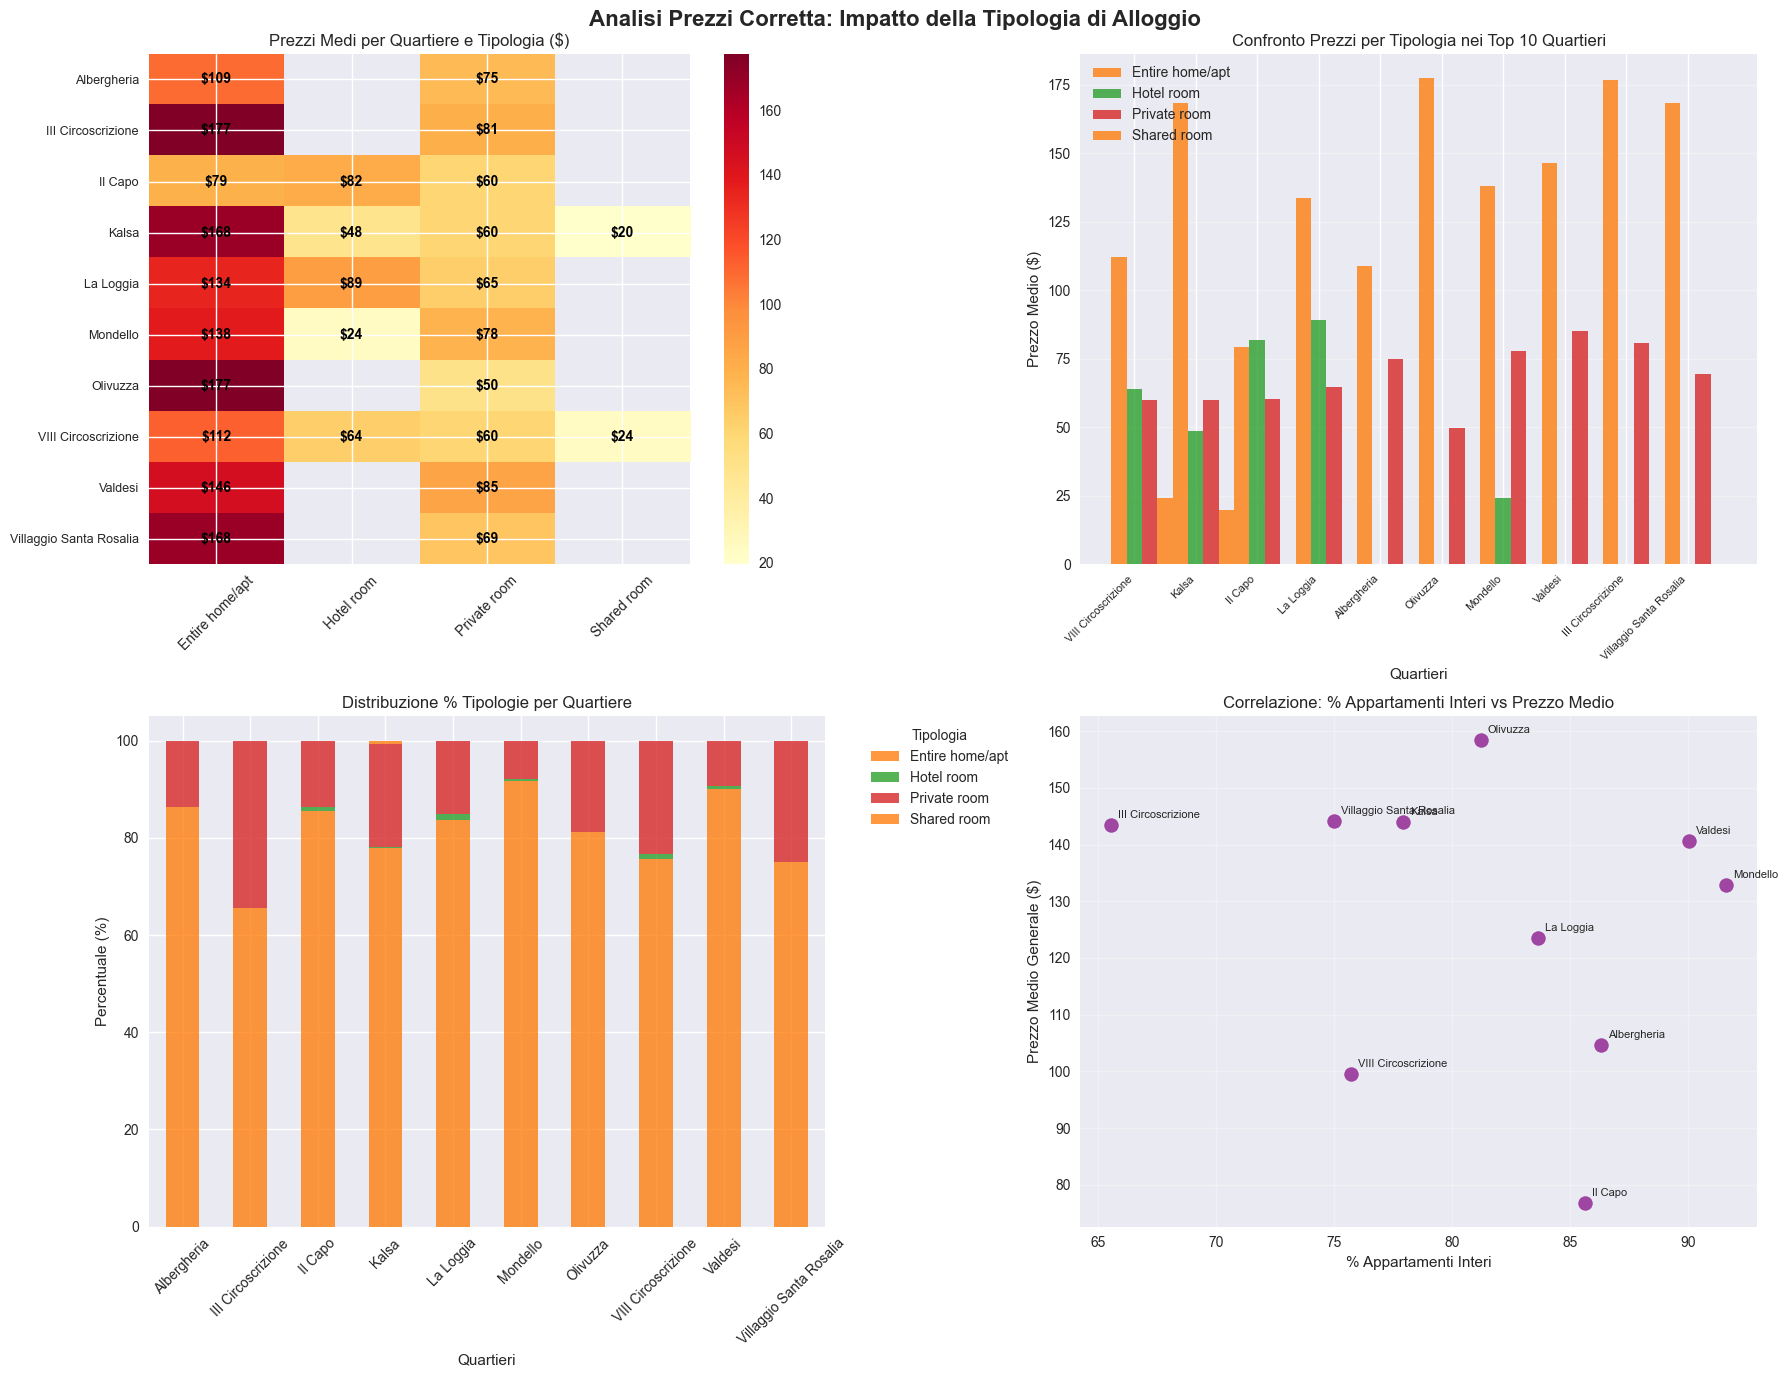

In [38]:
# SOLUZIONE: ANALISI CORRETTA DEI PREZZI PER QUARTIERE
# Consideriamo la tipologia di alloggio per un confronto equo

print("\n=== ANALISI CORRETTA: PREZZI PER QUARTIERE E TIPOLOGIA ===\n")

# Calcoliamo i prezzi medi per quartiere e tipologia
price_by_district_and_type = df_price.groupby(['district_area', 'room_type'])['price_numeric'].agg(['mean', 'count']).reset_index()
price_by_district_and_type.columns = ['district_area', 'room_type', 'avg_price', 'count']

# Filtriamo i top 10 quartieri per numero di annunci
top_districts_detailed = []
for district in top_10_districts:
    district_data = price_by_district_and_type[price_by_district_and_type['district_area'] == district]
    if len(district_data) > 0:
        top_districts_detailed.append(district_data)

if top_districts_detailed:
    detailed_analysis = pd.concat(top_districts_detailed)
    
    # Visualizzazione migliorata
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Analisi Prezzi Corretta: Impatto della Tipologia di Alloggio', fontsize=16, fontweight='bold')
    
    # 1. Heatmap prezzi per quartiere e tipologia
    pivot_data = detailed_analysis.pivot(index='district_area', columns='room_type', values='avg_price')
    im = ax1.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
    ax1.set_xticks(range(len(pivot_data.columns)))
    ax1.set_xticklabels(pivot_data.columns, rotation=45)
    ax1.set_yticks(range(len(pivot_data.index)))
    ax1.set_yticklabels(pivot_data.index, fontsize=9)
    ax1.set_title('Prezzi Medi per Quartiere e Tipologia ($)')
    
    # Aggiunta valori nella heatmap
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            value = pivot_data.iloc[i, j]
            if not pd.isna(value):
                ax1.text(j, i, f'${value:.0f}', ha='center', va='center', 
                        color='white' if value > pivot_data.values.mean() else 'black', fontweight='bold')
    
    plt.colorbar(im, ax=ax1)
    
    # 2. Grafico a barre raggruppate per tipologia
    room_types = detailed_analysis['room_type'].unique()
    x_pos = np.arange(len(top_10_districts))
    width = 0.25
    
    colors = ['#ff7f0e', '#2ca02c', '#d62728']
    for i, room_type in enumerate(room_types):
        prices = []
        for district in top_10_districts:
            district_room_data = detailed_analysis[
                (detailed_analysis['district_area'] == district) & 
                (detailed_analysis['room_type'] == room_type)
            ]
            if len(district_room_data) > 0:
                prices.append(district_room_data['avg_price'].iloc[0])
            else:
                prices.append(0)
        
        ax2.bar(x_pos + i*width, prices, width, label=room_type, 
               color=colors[i % len(colors)], alpha=0.8)
    
    ax2.set_xlabel('Quartieri')
    ax2.set_ylabel('Prezzo Medio ($)')
    ax2.set_title('Confronto Prezzi per Tipologia nei Top 10 Quartieri')
    ax2.set_xticks(x_pos + width)
    ax2.set_xticklabels(top_10_districts, rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Distribuzione percentuale tipologie per quartiere
    district_type_counts = df_price[df_price['district_area'].isin(top_10_districts)].groupby(['district_area', 'room_type']).size().unstack(fill_value=0)
    district_type_percentages = district_type_counts.div(district_type_counts.sum(axis=1), axis=0) * 100
    
    district_type_percentages.plot(kind='bar', stacked=True, ax=ax3, 
                                  color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
    ax3.set_title('Distribuzione % Tipologie per Quartiere')
    ax3.set_xlabel('Quartieri')
    ax3.set_ylabel('Percentuale (%)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(title='Tipologia', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Scatter plot: composizione vs prezzo medio generale
    general_avg_by_district = df_price[df_price['district_area'].isin(top_10_districts)].groupby('district_area')['price_numeric'].mean()
    entire_home_percentage = district_type_percentages.get('Entire home/apt', pd.Series(0, index=district_type_percentages.index))
    
    ax4.scatter(entire_home_percentage, general_avg_by_district, s=100, alpha=0.7, color='purple')
    ax4.set_xlabel('% Appartamenti Interi')
    ax4.set_ylabel('Prezzo Medio Generale ($)')
    ax4.set_title('Correlazione: % Appartamenti Interi vs Prezzo Medio')
    
    # Aggiungiamo etichette ai punti
    for district, x, y in zip(general_avg_by_district.index, entire_home_percentage, general_avg_by_district):
        ax4.annotate(district, (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


=== RANKING CORRETTO DEI QUARTIERI ===

🔍 METODO 1: PREZZO MEDIO PONDERATO
Normalizza i prezzi considerando la distribuzione nazionale delle tipologie

Distribuzione nazionale delle tipologie:
  • Entire home/apt: 81.3%
  • Private room: 18.2%
  • Hotel room: 0.4%
  • Shared room: 0.1%

Ranking Quartieri - Confronto Prezzo Originale vs Normalizzato:
Pos Quartiere                 Orig($)  Norm($)  Diff($)  Annunci 
1   III Circoscrizione        143      159      16       151     
2   Olivuzza                  159      154      -4       229     
3   Villaggio Santa Rosalia   144      150      6        144     
4   Kalsa                     144      148      4        830     
5   Mondello                  133      126      -6       191     
6   La Loggia                 124      121      -3       600     
7   Albergheria               105      103      -2       571     
8   VIII Circoscrizione       100      102      3        972     
9   Il Capo                   77       76       -1   


=== RANKING CORRETTO DEI QUARTIERI ===

🔍 METODO 1: PREZZO MEDIO PONDERATO
Normalizza i prezzi considerando la distribuzione nazionale delle tipologie

Distribuzione nazionale delle tipologie:
  • Entire home/apt: 81.3%
  • Private room: 18.2%
  • Hotel room: 0.4%
  • Shared room: 0.1%

Ranking Quartieri - Confronto Prezzo Originale vs Normalizzato:
Pos Quartiere                 Orig($)  Norm($)  Diff($)  Annunci 
1   III Circoscrizione        143      159      16       151     
2   Olivuzza                  159      154      -4       229     
3   Villaggio Santa Rosalia   144      150      6        144     
4   Kalsa                     144      148      4        830     
5   Mondello                  133      126      -6       191     
6   La Loggia                 124      121      -3       600     
7   Albergheria               105      103      -2       571     
8   VIII Circoscrizione       100      102      3        972     
9   Il Capo                   77       76       -1   

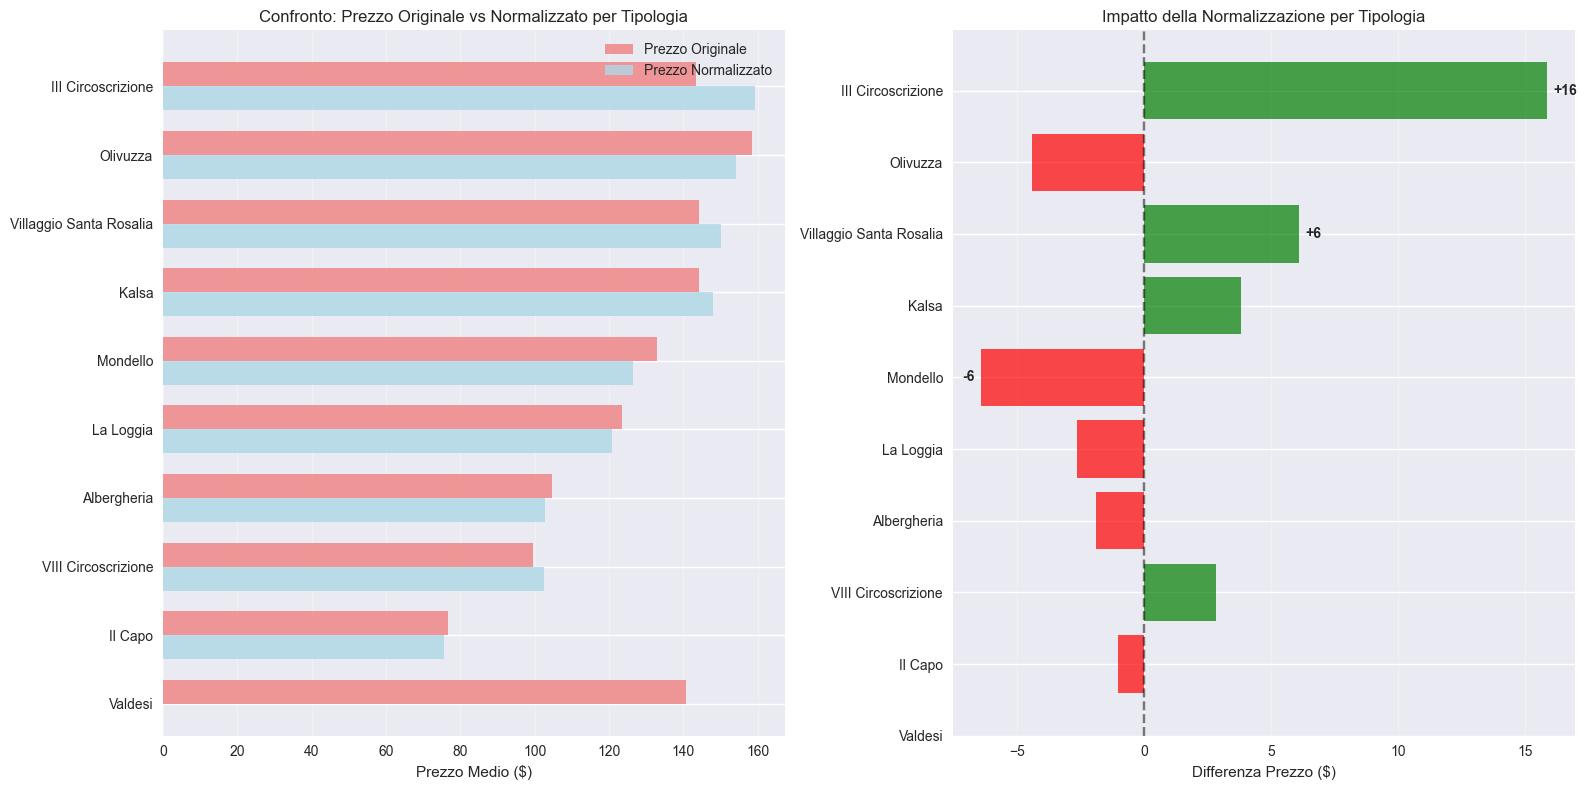


📊 INSIGHTS CHIAVE:

• Quartiere con maggior AUMENTO dopo normalizzazione:
  III Circoscrizione: +$16 (da $143 a $159)

• Quartiere con maggior DIMINUZIONE dopo normalizzazione:
  Mondello: -6 (da $133 a $126)

• Questo dimostra che i quartieri con più appartamenti interi avevano prezzi 'gonfiati'
• Mentre quartieri con più stanze private/condivise erano 'sottovalutati'
• Il ranking normalizzato offre una valutazione più equa per investimenti


In [31]:
# RANKING CORRETTO: PREZZO NORMALIZZATO PER TIPOLOGIA
print("\n=== RANKING CORRETTO DEI QUARTIERI ===\n")

# Metodo 1: Prezzo medio ponderato per tipologia
print("🔍 METODO 1: PREZZO MEDIO PONDERATO")
print("Normalizza i prezzi considerando la distribuzione nazionale delle tipologie\n")

# Distribuzione nazionale delle tipologie (come riferimento)
national_distribution = df_price['room_type'].value_counts(normalize=True)
print("Distribuzione nazionale delle tipologie:")
for room_type, percentage in national_distribution.items():
    print(f"  • {room_type}: {percentage:.1%}")

# Calcolo prezzo normalizzato per quartiere
normalized_prices = []
for district in top_10_districts:
    district_data = df_price[df_price['district_area'] == district]
    if len(district_data) > 0:
        weighted_price = 0
        total_weight = 0
        
        for room_type in df_price['room_type'].unique():
            room_data = district_data[district_data['room_type'] == room_type]
            if len(room_data) > 0:
                room_avg_price = room_data['price_numeric'].mean()
                weight = national_distribution[room_type]  # Peso nazionale
                weighted_price += room_avg_price * weight
                total_weight += weight
        
        if total_weight > 0:
            normalized_price = weighted_price / total_weight
        else:
            normalized_price = district_data['price_numeric'].mean()
        
        normalized_prices.append({
            'district': district,
            'original_avg': district_data['price_numeric'].mean(),
            'normalized_avg': normalized_price,
            'difference': normalized_price - district_data['price_numeric'].mean(),
            'num_listings': len(district_data)
        })

# Creiamo DataFrame per l'analisi
normalized_df = pd.DataFrame(normalized_prices)
normalized_df = normalized_df.sort_values('normalized_avg', ascending=False)

print("\nRanking Quartieri - Confronto Prezzo Originale vs Normalizzato:")
print("=" * 80)
print(f"{'Pos':<3} {'Quartiere':<25} {'Orig($)':<8} {'Norm($)':<8} {'Diff($)':<8} {'Annunci':<8}")
print("=" * 80)

for i, row in normalized_df.iterrows():
    pos = normalized_df.index.get_loc(i) + 1
    print(f"{pos:<3} {row['district']:<25} {row['original_avg']:<8.0f} {row['normalized_avg']:<8.0f} {row['difference']:<8.0f} {row['num_listings']:<8}")

# Visualizzazione del confronto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Grafico 1: Confronto ranking originale vs normalizzato
y_pos = np.arange(len(normalized_df))
width = 0.35

ax1.barh(y_pos - width/2, normalized_df['original_avg'], width, 
         label='Prezzo Originale', color='lightcoral', alpha=0.8)
ax1.barh(y_pos + width/2, normalized_df['normalized_avg'], width,
         label='Prezzo Normalizzato', color='lightblue', alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(normalized_df['district'], fontsize=10)
ax1.set_xlabel('Prezzo Medio ($)')
ax1.set_title('Confronto: Prezzo Originale vs Normalizzato per Tipologia')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Grafico 2: Differenza assoluta
differences = normalized_df['difference']
colors = ['red' if x < 0 else 'green' for x in differences]
ax2.barh(y_pos, differences, color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(normalized_df['district'], fontsize=10)
ax2.set_xlabel('Differenza Prezzo ($)')
ax2.set_title('Impatto della Normalizzazione per Tipologia')
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Aggiungiamo annotazioni
for i, (diff, district) in enumerate(zip(differences, normalized_df['district'])):
    if abs(diff) > 5:  # Solo differenze significative
        ax2.annotate(f'{diff:+.0f}', (diff, i), xytext=(5 if diff > 0 else -5, 0), 
                    textcoords='offset points', va='center', 
                    ha='left' if diff > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 INSIGHTS CHIAVE:")
max_increase = normalized_df.loc[normalized_df['difference'].idxmax()]
max_decrease = normalized_df.loc[normalized_df['difference'].idxmin()]

print(f"\n• Quartiere con maggior AUMENTO dopo normalizzazione:")
print(f"  {max_increase['district']}: +${max_increase['difference']:.0f} (da ${max_increase['original_avg']:.0f} a ${max_increase['normalized_avg']:.0f})")
print(f"\n• Quartiere con maggior DIMINUZIONE dopo normalizzazione:")
print(f"  {max_decrease['district']}: {max_decrease['difference']:.0f} (da ${max_decrease['original_avg']:.0f} a ${max_decrease['normalized_avg']:.0f})")

print(f"\n• Questo dimostra che i quartieri con più appartamenti interi avevano prezzi 'gonfiati'")
print(f"• Mentre quartieri con più stanze private/condivise erano 'sottovalutati'")
print(f"• Il ranking normalizzato offre una valutazione più equa per investimenti")

In [32]:
# ANALISI STRATEGICA PER INVESTIMENTI
print("\n=== ANALISI STRATEGICA PER INVESTIMENTI ===\n")

# Metodo 2: Analisi per tipologia specifica
print("🏠 METODO 2: RANKING PER TIPOLOGIA SPECIFICA")
print("Ideale per investitori che vogliono puntare su una tipologia specifica\n")

for room_type in df_price['room_type'].unique():
    print(f"\n📍 TOP 5 QUARTIERI PER {room_type.upper()}:")
    room_type_data = df_price[df_price['room_type'] == room_type]
    room_type_by_district = room_type_data.groupby('district_area').agg({
        'price_numeric': ['mean', 'count'],
        'availability_30': 'mean'
    }).round(2)
    
    room_type_by_district.columns = ['avg_price', 'listings_count', 'avg_availability']
    
    # Filtriamo quartieri con almeno 3 annunci per questa tipologia
    room_type_filtered = room_type_by_district[room_type_by_district['listings_count'] >= 3]
    room_type_sorted = room_type_filtered.sort_values('avg_price', ascending=False).head(5)
    
    for i, (district, row) in enumerate(room_type_sorted.iterrows(), 1):
        availability_status = "🔴 Alto" if row['avg_availability'] > 20 else "🟡 Medio" if row['avg_availability'] > 10 else "🟢 Basso"
        print(f"  {i}. {district}: ${row['avg_price']:.0f} ({row['listings_count']} annunci) - Disponibilità: {availability_status}")

# Analisi delle opportunità
print("\n\n💡 OPPORTUNITÀ DI INVESTIMENTO IDENTIFICATE:")
print("=" * 60)

# Quartieri sottovalutati (prezzo normalizzato > prezzo originale)
undervalued = normalized_df[normalized_df['difference'] > 10].sort_values('difference', ascending=False)
if len(undervalued) > 0:
    print("\n🔥 QUARTIERI SOTTOVALUTATI (Opportunità):")
    for _, row in undervalued.iterrows():
        print(f"  • {row['district']}: Potenziale +${row['difference']:.0f} per tipologia")

# Quartieri sopravvalutati (prezzo normalizzato < prezzo originale)  
overvalued = normalized_df[normalized_df['difference'] < -10].sort_values('difference')
if len(overvalued) > 0:
    print("\n⚠️  QUARTIERI SOPRAVVALUTATI (Attenzione):")
    for _, row in overvalued.iterrows():
        print(f"  • {row['district']}: Prezzo gonfiato di ${abs(row['difference']):.0f} per tipologia")

# Raccomandazioni strategiche
print("\n\n🎯 RACCOMANDAZIONI STRATEGICHE:")
print("=" * 50)
print("\n1. PER INVESTITORI IN APPARTAMENTI INTERI:")
entire_homes = df_price[df_price['room_type'] == 'Entire home/apt'].groupby('district_area').agg({
    'price_numeric': 'mean',
    'availability_30': 'mean'
}).round(2)
entire_homes = entire_homes[entire_homes.index.isin(top_10_districts)]
best_entire_homes = entire_homes.sort_values(['availability_30', 'price_numeric'], ascending=[False, True]).head(3)

for i, (district, row) in enumerate(best_entire_homes.iterrows(), 1):
    print(f"  {i}. {district}: ${row['price_numeric']:.0f} - Disponibilità: {row['availability_30']:.1f} giorni")

print("\n2. PER INVESTITORI IN STANZE PRIVATE:")
private_rooms = df_price[df_price['room_type'] == 'Private room'].groupby('district_area').agg({
    'price_numeric': 'mean',
    'availability_30': 'mean'
}).round(2)
private_rooms = private_rooms[private_rooms.index.isin(top_10_districts)]
best_private_rooms = private_rooms.sort_values(['availability_30', 'price_numeric'], ascending=[False, True]).head(3)

for i, (district, row) in enumerate(best_private_rooms.iterrows(), 1):
    print(f"  {i}. {district}: ${row['price_numeric']:.0f} - Disponibilità: {row['availability_30']:.1f} giorni")

print("\n3. DIVERSIFICAZIONE PORTFOLIO:")
# Quartieri con buon mix di tipologie
diverse_districts = []
for district in top_10_districts:
    district_data = df_price[df_price['district_area'] == district]
    room_types_count = district_data['room_type'].nunique()
    if room_types_count >= 2:  # Almeno 2 tipologie diverse
        avg_price = district_data['price_numeric'].mean()
        avg_availability = district_data['availability_30'].mean()
        diverse_districts.append({
            'district': district,
            'types_count': room_types_count,
            'avg_price': avg_price,
            'avg_availability': avg_availability
        })

diverse_df = pd.DataFrame(diverse_districts).sort_values(['types_count', 'avg_availability'], ascending=[False, False]).head(3)
for i, row in diverse_df.iterrows():
    print(f"  • {row['district']}: {row['types_count']} tipologie - ${row['avg_price']:.0f} - {row['avg_availability']:.1f} giorni disp.")

print("\n\n✅ CONCLUSIONI:")
print("• L'analisi tradizionale per quartiere nasconde importanti differenze di tipologia")
print("• Alcuni quartieri sembrano costosi solo perché hanno più appartamenti interi")
print("• Altri quartieri offrono opportunità sottovalutate per stanze private")
print("• Una strategia di investimento dovrebbe sempre considerare il mix di tipologie")


=== ANALISI STRATEGICA PER INVESTIMENTI ===

🏠 METODO 2: RANKING PER TIPOLOGIA SPECIFICA
Ideale per investitori che vogliono puntare su una tipologia specifica


📍 TOP 5 QUARTIERI PER ENTIRE HOME/APT:
  1. Addaura: $375 (87.0 annunci) - Disponibilità: 🟡 Medio
  2. Guadagna: $232 (34.0 annunci) - Disponibilità: 🟡 Medio
  3. Zen: $229 (21.0 annunci) - Disponibilità: 🟡 Medio
  4. Partanna: $194 (105.0 annunci) - Disponibilità: 🟡 Medio
  5. Olivuzza: $177 (178.0 annunci) - Disponibilità: 🟡 Medio

📍 TOP 5 QUARTIERI PER PRIVATE ROOM:
  1. Partanna: $165 (10.0 annunci) - Disponibilità: 🔴 Alto
  2. II Circoscrizione: $105 (22.0 annunci) - Disponibilità: 🟡 Medio
  3. Valdesi: $85 (16.0 annunci) - Disponibilità: 🟡 Medio
  4. III Circoscrizione: $81 (50.0 annunci) - Disponibilità: 🟡 Medio
  5. Arenella: $78 (6.0 annunci) - Disponibilità: 🟡 Medio

📍 TOP 5 QUARTIERI PER HOTEL ROOM:
  1. La Loggia: $89 (5.0 annunci) - Disponibilità: 🟢 Basso
  2. Il Capo: $82 (4.0 annunci) - Disponibilità: 🟢 Basso
 

Top 10 quartieri per disponibilità (30 giorni):
Falsomiele: 29.7 giorni disponibili
Molara: 29.0 giorni disponibili
Passo di Rigano: 25.5 giorni disponibili
Roccella: 25.2 giorni disponibili
Pagliarelli: 23.0 giorni disponibili
Boccadifalco: 22.7 giorni disponibili
Patti: 19.8 giorni disponibili
Altarello: 19.6 giorni disponibili
Uditore: 19.0 giorni disponibili
Zen: 17.5 giorni disponibili


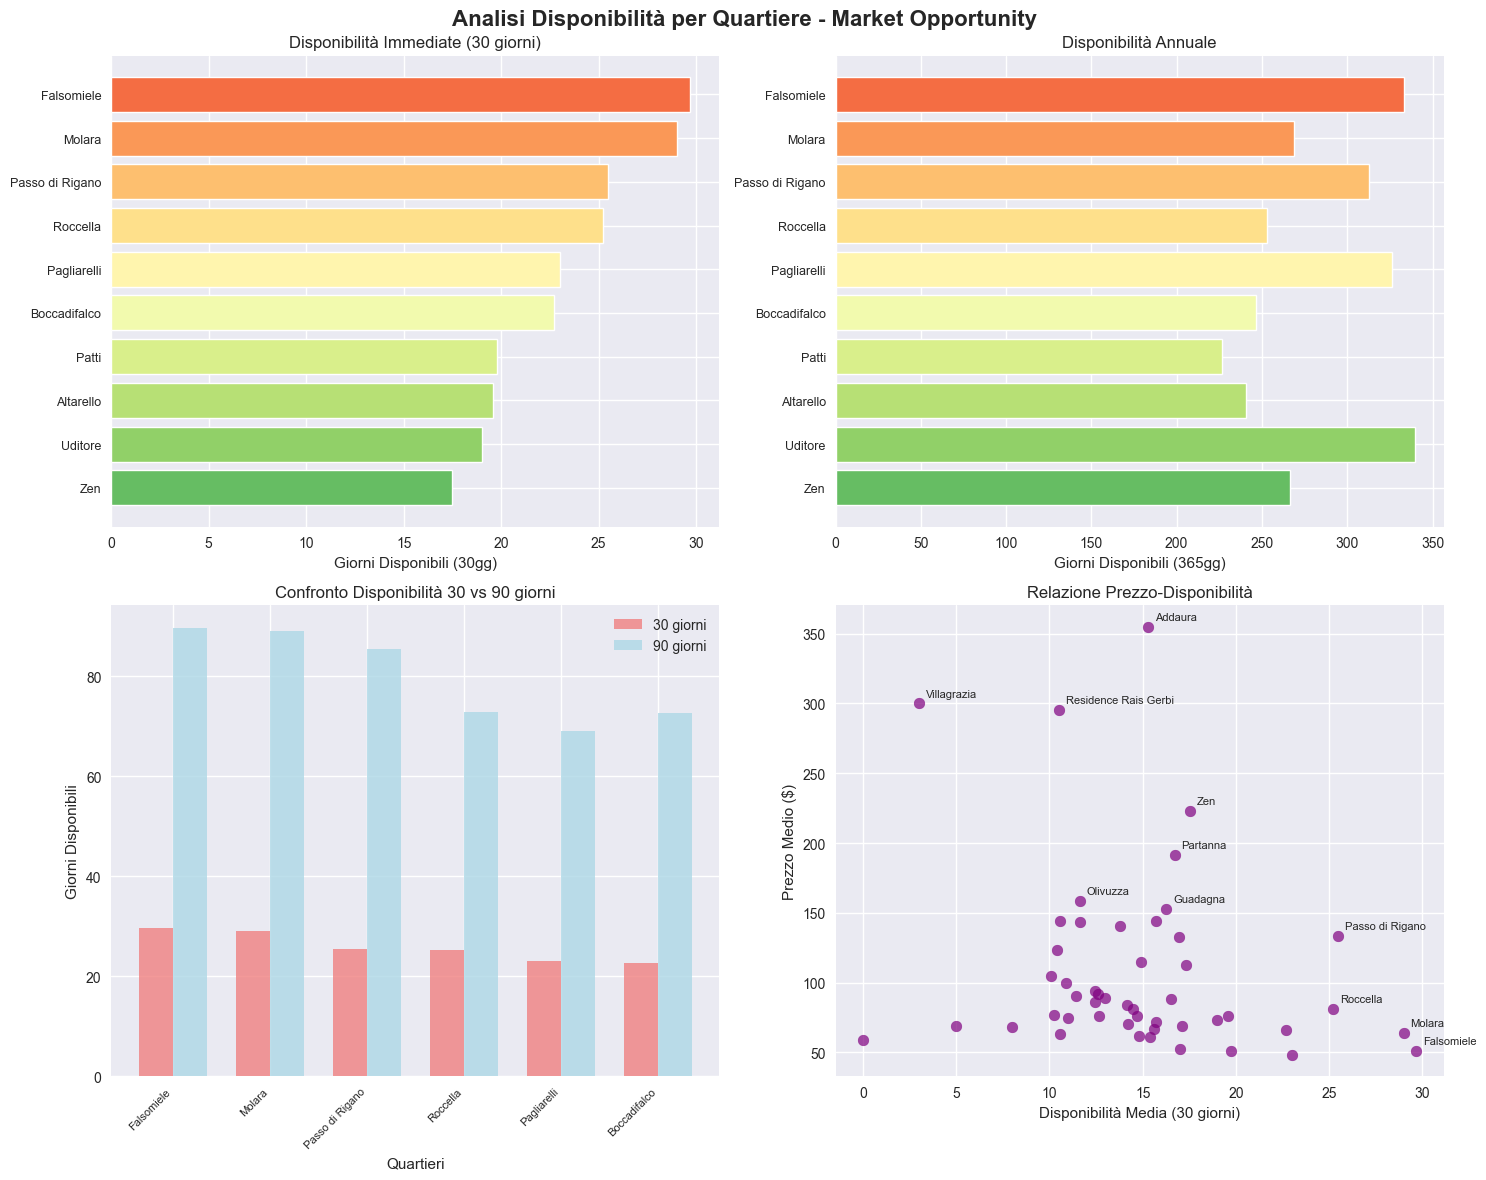


=== INSIGHTS STRATEGICI ===
Mercati SATURI (bassa disponibilità): 0 quartieri

OPPORTUNITÀ (alta disponibilità): 6 quartieri
Maggiore opportunità: Falsomiele (29.7 giorni)


In [26]:
# 1. ANALISI DISPONIBILITÀ PER QUARTIERE
# Importante per identificare mercati saturi vs opportunità

# Calcoliamo la disponibilità media per quartiere
availability_by_district = df_price.groupby('district_area').agg({
    'availability_30': 'mean',
    'availability_60': 'mean', 
    'availability_90': 'mean',
    'availability_365': 'mean'
}).round(1)

# Ordiniamo per disponibilità a 30 giorni (indicatore chiave)
availability_sorted = availability_by_district.sort_values('availability_30', ascending=False).head(10)

print("Top 10 quartieri per disponibilità (30 giorni):")
for district, row in availability_sorted.iterrows():
    print(f"{district}: {row['availability_30']:.1f} giorni disponibili")

# Visualizzazione
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analisi Disponibilità per Quartiere - Market Opportunity', fontsize=16, fontweight='bold')

# Grafico 1: Disponibilità 30 giorni
colors_avail = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(availability_sorted)))
bars1 = ax1.barh(range(len(availability_sorted)), availability_sorted['availability_30'], 
                 color=colors_avail, edgecolor='white', linewidth=1)
ax1.set_yticks(range(len(availability_sorted)))
ax1.set_yticklabels(availability_sorted.index, fontsize=9)
ax1.set_xlabel('Giorni Disponibili (30gg)')
ax1.set_title('Disponibilità Immediate (30 giorni)')
ax1.invert_yaxis()

# Grafico 2: Disponibilità 365 giorni
bars2 = ax2.barh(range(len(availability_sorted)), availability_sorted['availability_365'], 
                 color=colors_avail, edgecolor='white', linewidth=1)
ax2.set_yticks(range(len(availability_sorted)))
ax2.set_yticklabels(availability_sorted.index, fontsize=9)
ax2.set_xlabel('Giorni Disponibili (365gg)')
ax2.set_title('Disponibilità Annuale')
ax2.invert_yaxis()

# Grafico 3: Confronto disponibilità
districts_sample = availability_sorted.head(6)
x_pos = np.arange(len(districts_sample))
width = 0.35

ax3.bar(x_pos - width/2, districts_sample['availability_30'], width, 
        label='30 giorni', color='lightcoral', alpha=0.8)
ax3.bar(x_pos + width/2, districts_sample['availability_90'], width,
        label='90 giorni', color='lightblue', alpha=0.8)

ax3.set_xlabel('Quartieri')
ax3.set_ylabel('Giorni Disponibili')
ax3.set_title('Confronto Disponibilità 30 vs 90 giorni')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(districts_sample.index, rotation=45, ha='right', fontsize=8)
ax3.legend()

# Grafico 4: Scatter plot prezzo vs disponibilità
price_avail_data = df_price.groupby('district_area').agg({
    'price_numeric': 'mean',
    'availability_30': 'mean'
}).dropna()

ax4.scatter(price_avail_data['availability_30'], price_avail_data['price_numeric'], 
           alpha=0.7, s=60, color='purple')
ax4.set_xlabel('Disponibilità Media (30 giorni)')
ax4.set_ylabel('Prezzo Medio ($)')
ax4.set_title('Relazione Prezzo-Disponibilità')

# Aggiungiamo etichette per i punti più interessanti
for district, row in price_avail_data.iterrows():
    if row['availability_30'] > 25 or row['price_numeric'] > 150:
        ax4.annotate(district, (row['availability_30'], row['price_numeric']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Insights strategici
print("\n=== INSIGHTS STRATEGICI ===")
low_availability = availability_sorted[availability_sorted['availability_30'] < 10]
high_availability = availability_sorted[availability_sorted['availability_30'] > 20]

print(f"Mercati SATURI (bassa disponibilità): {len(low_availability)} quartieri")
if len(low_availability) > 0:
    print(f"Più saturo: {low_availability.index[-1]} ({low_availability['availability_30'].iloc[-1]:.1f} giorni)")

print(f"\nOPPORTUNITÀ (alta disponibilità): {len(high_availability)} quartieri")
if len(high_availability) > 0:
    print(f"Maggiore opportunità: {high_availability.index[0]} ({high_availability['availability_30'].iloc[0]:.1f} giorni)")

Top 10 quartieri per qualità (review scores):
Pagliarelli: 5.00/5.0
Molara: 5.00/5.0
Baida: 4.94/5.0
Residence Rais Gerbi: 4.94/5.0
Boccadifalco: 4.92/5.0
Uditore: 4.91/5.0
Chiavelli: 4.88/5.0
Vallone: 4.87/5.0
Resuttana: 4.86/5.0
San Lorenzo: 4.85/5.0

=== INSIGHTS QUALITÀ ===
Quartieri ALTA QUALITÀ (>4.8): 10
Migliore: Pagliarelli (5.00)

Quartieri da MIGLIORARE (<4.7): 0


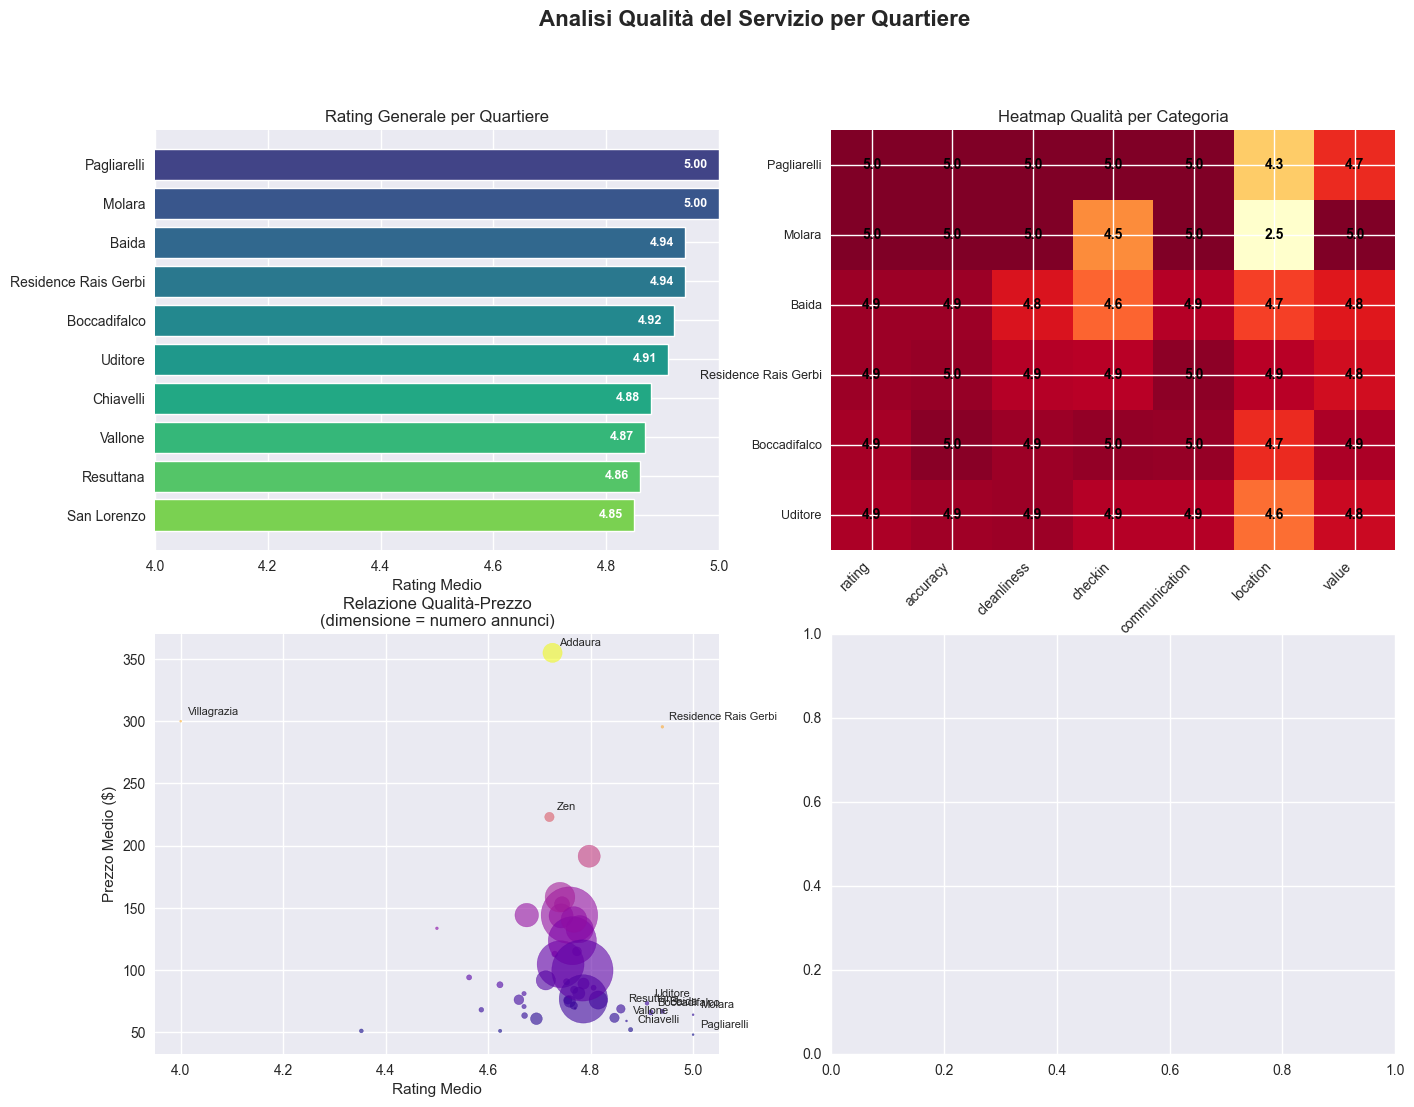

In [27]:
# 2. ANALISI REVIEW SCORES PER QUARTIERE
# Fondamentale per identificare la qualità del servizio per area

# Calcoliamo i punteggi medi per quartiere
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
               'review_scores_value']

review_by_district = df_price.groupby('district_area')[review_cols].mean().round(2)
review_by_district = review_by_district.dropna()

# Ordiniamo per rating generale
review_sorted = review_by_district.sort_values('review_scores_rating', ascending=False).head(10)

print("Top 10 quartieri per qualità (review scores):")
for district, row in review_sorted.iterrows():
    print(f"{district}: {row['review_scores_rating']:.2f}/5.0")

# Visualizzazione avanzata
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Qualità del Servizio per Quartiere', fontsize=16, fontweight='bold')

# Grafico 1: Rating generale per quartiere
colors_review = plt.cm.viridis(np.linspace(0.2, 0.8, len(review_sorted)))
bars = ax1.barh(range(len(review_sorted)), review_sorted['review_scores_rating'], 
                color=colors_review, edgecolor='white', linewidth=1)
ax1.set_yticks(range(len(review_sorted)))
ax1.set_yticklabels(review_sorted.index, fontsize=10)
ax1.set_xlabel('Rating Medio')
ax1.set_title('Rating Generale per Quartiere')
ax1.set_xlim(4.0, 5.0)  # Focus sulla scala reale
ax1.invert_yaxis()

# Aggiungiamo i valori sulle barre
for i, (bar, value) in enumerate(zip(bars, review_sorted['review_scores_rating'])):
    ax1.text(value - 0.02, i, f'{value:.2f}', va='center', ha='right', 
             fontweight='bold', fontsize=9, color='white')

# Grafico 2: Heatmap delle categorie di review
top_6_districts = review_sorted.head(6)
review_categories = ['rating', 'accuracy', 'cleanliness', 'checkin', 'communication', 'location', 'value']
review_data_matrix = top_6_districts[review_cols].values

im = ax2.imshow(review_data_matrix, cmap='YlOrRd', aspect='auto', vmin=4.0, vmax=5.0)
ax2.set_xticks(range(len(review_categories)))
ax2.set_xticklabels(review_categories, rotation=45, ha='right')
ax2.set_yticks(range(len(top_6_districts)))
ax2.set_yticklabels(top_6_districts.index, fontsize=9)
ax2.set_title('Heatmap Qualità per Categoria')

# Aggiungiamo i valori nella heatmap
for i in range(len(top_6_districts)):
    for j in range(len(review_categories)):
        text = ax2.text(j, i, f'{review_data_matrix[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Grafico 3: Scatter plot qualità vs prezzo
quality_price_data = df_price.groupby('district_area').agg({
    'review_scores_rating': 'mean',
    'price_numeric': 'mean',
    'id': 'count'  # numero di annunci per dimensione del punto
}).dropna()

scatter = ax3.scatter(quality_price_data['review_scores_rating'], 
                     quality_price_data['price_numeric'],
                     s=quality_price_data['id']*2,  # dimensione basata su numero annunci
                     alpha=0.6, c=quality_price_data['price_numeric'], 
                     cmap='plasma')
ax3.set_xlabel('Rating Medio')
ax3.set_ylabel('Prezzo Medio ($)')
ax3.set_title('Relazione Qualità-Prezzo\n(dimensione = numero annunci)')

# Etichette per quartieri interessanti
for district, row in quality_price_data.iterrows():
    if row['review_scores_rating'] > 4.85 or row['price_numeric'] > 200:
        ax3.annotate(district, (row['review_scores_rating'], row['price_numeric']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)


# Insights di business
print("\n=== INSIGHTS QUALITÀ ===")
high_quality = review_sorted[review_sorted['review_scores_rating'] > 4.8]
low_quality = review_sorted[review_sorted['review_scores_rating'] < 4.7]

print(f"Quartieri ALTA QUALITÀ (>4.8): {len(high_quality)}")
if len(high_quality) > 0:
    print(f"Migliore: {high_quality.index[0]} ({high_quality['review_scores_rating'].iloc[0]:.2f})")

print(f"\nQuartieri da MIGLIORARE (<4.7): {len(low_quality)}")
if len(low_quality) > 0:
    print(f"Priorità intervento: {low_quality.index[-1]} ({low_quality['review_scores_rating'].iloc[-1]:.2f})")

In [ ]:
# 3. ANALISI TIPOLOGIA PROPRIETÀ PER QUARTIERE
# Importante per capire le preferenze del mercato locale

# Analisi delle tipologie di proprietà per quartiere
property_district = pd.crosstab(df_price['district_area'], df_price['property_type'])
room_district = pd.crosstab(df_price['district_area'], df_price['room_type'])

# Top quartieri per analisi
top_districts = district_counts.head(8).index

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Tipologie di Proprietà per Quartiere', fontsize=16, fontweight='bold')

# Grafico 1: Room type distribution per top quartieri
room_top_districts = room_district.loc[top_districts]
room_percentages = room_top_districts.div(room_top_districts.sum(axis=1), axis=0) * 100

room_percentages.plot(kind='bar', stacked=True, ax=ax1, 
                     color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Distribuzione Tipologie di Camera per Quartiere (%)')
ax1.set_xlabel('Quartieri')
ax1.set_ylabel('Percentuale')
ax1.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Grafico 2: Property type (top types) per quartieri
# Selezioniamo i tipi di proprietà più comuni
top_property_types = df_price['property_type'].value_counts().head(5).index
property_filtered = property_district[top_property_types].loc[top_districts]

property_filtered.plot(kind='bar', ax=ax2, 
                      color=plt.cm.Set3(np.linspace(0, 1, len(top_property_types))))
ax2.set_title('Distribuzione Tipi di Proprietà per Quartiere')
ax2.set_xlabel('Quartieri')
ax2.set_ylabel('Numero di Annunci')
ax2.legend(title='Property Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# Grafico 3: Accommodates (capacità ospiti) per quartiere
accommodates_district = df_price.groupby('district_area')['accommodates'].agg(['mean', 'median']).round(1)
accommodates_top = accommodates_district.loc[top_districts]

x_pos = np.arange(len(accommodates_top))
width = 0.35

ax3.bar(x_pos - width/2, accommodates_top['mean'], width, 
        label='Media', color='lightcoral', alpha=0.8)
ax3.bar(x_pos + width/2, accommodates_top['median'], width,
        label='Mediana', color='lightblue', alpha=0.8)

ax3.set_xlabel('Quartieri')
ax3.set_ylabel('Numero Ospiti')
ax3.set_title('Capacità Media di Ospiti per Quartiere')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(accommodates_top.index, rotation=45, ha='right')
ax3.legend()

# Grafico 4: Instant bookable vs non per quartiere
instant_district = pd.crosstab(df_price['district_area'], df_price['instant_bookable'])
instant_top = instant_district.loc[top_districts]
instant_pct = instant_top.div(instant_top.sum(axis=1), axis=0) * 100

instant_pct.plot(kind='bar', ax=ax4, color=['#FF9999', '#66B2FF'])
ax4.set_title('Percentuale Instant Bookable per Quartiere')
ax4.set_xlabel('Quartieri')
ax4.set_ylabel('Percentuale')
ax4.legend(title='Instant Bookable', labels=['No', 'Si'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analisi dettagliata
print("\n=== INSIGHTS TIPOLOGIE PROPRIETÀ ===")
print("\nTipologie di camera più popolari per quartiere:")
for district in top_districts[:5]:
    main_room_type = room_district.loc[district].idxmax()
    percentage = (room_district.loc[district, main_room_type] / room_district.loc[district].sum()) * 100
    print(f"{district}: {main_room_type} ({percentage:.1f}%)")

print("\nCapacità media ospiti per quartiere:")
for district in top_districts[:5]:
    avg_capacity = accommodates_district.loc[district, 'mean']
    print(f"{district}: {avg_capacity:.1f} ospiti")

# Quartieri con più instant bookable
instant_rates = instant_pct[True].sort_values(ascending=False)
print(f"\nQuartiere con più instant bookable: {instant_rates.index[0]} ({instant_rates.iloc[0]:.1f}%)")
print(f"Quartiere con meno instant bookable: {instant_rates.index[-1]} ({instant_rates.iloc[-1]:.1f}%)")

Top 10 quartieri per revenue stimato annuale:
Residence Rais Gerbi: $64,611 (occupancy: 208%)
I Circoscrizione: $13,248 (occupancy: 192%)
VII Circoscrizione: $11,404 (occupancy: 86%)
Kalsa: $11,096 (occupancy: 94%)
La Loggia: $9,311 (occupancy: 99%)
Albergheria: $8,313 (occupancy: 93%)
Addaura: $8,034 (occupancy: 53%)
Molara: $7,936 (occupancy: 124%)
V Circoscrizione: $6,940 (occupancy: 117%)
Il Capo: $6,370 (occupancy: 93%)


Top 10 quartieri per revenue stimato annuale:
Residence Rais Gerbi: $64,611 (occupancy: 208%)
I Circoscrizione: $13,248 (occupancy: 192%)
VII Circoscrizione: $11,404 (occupancy: 86%)
Kalsa: $11,096 (occupancy: 94%)
La Loggia: $9,311 (occupancy: 99%)
Albergheria: $8,313 (occupancy: 93%)
Addaura: $8,034 (occupancy: 53%)
Molara: $7,936 (occupancy: 124%)
V Circoscrizione: $6,940 (occupancy: 117%)
Il Capo: $6,370 (occupancy: 93%)


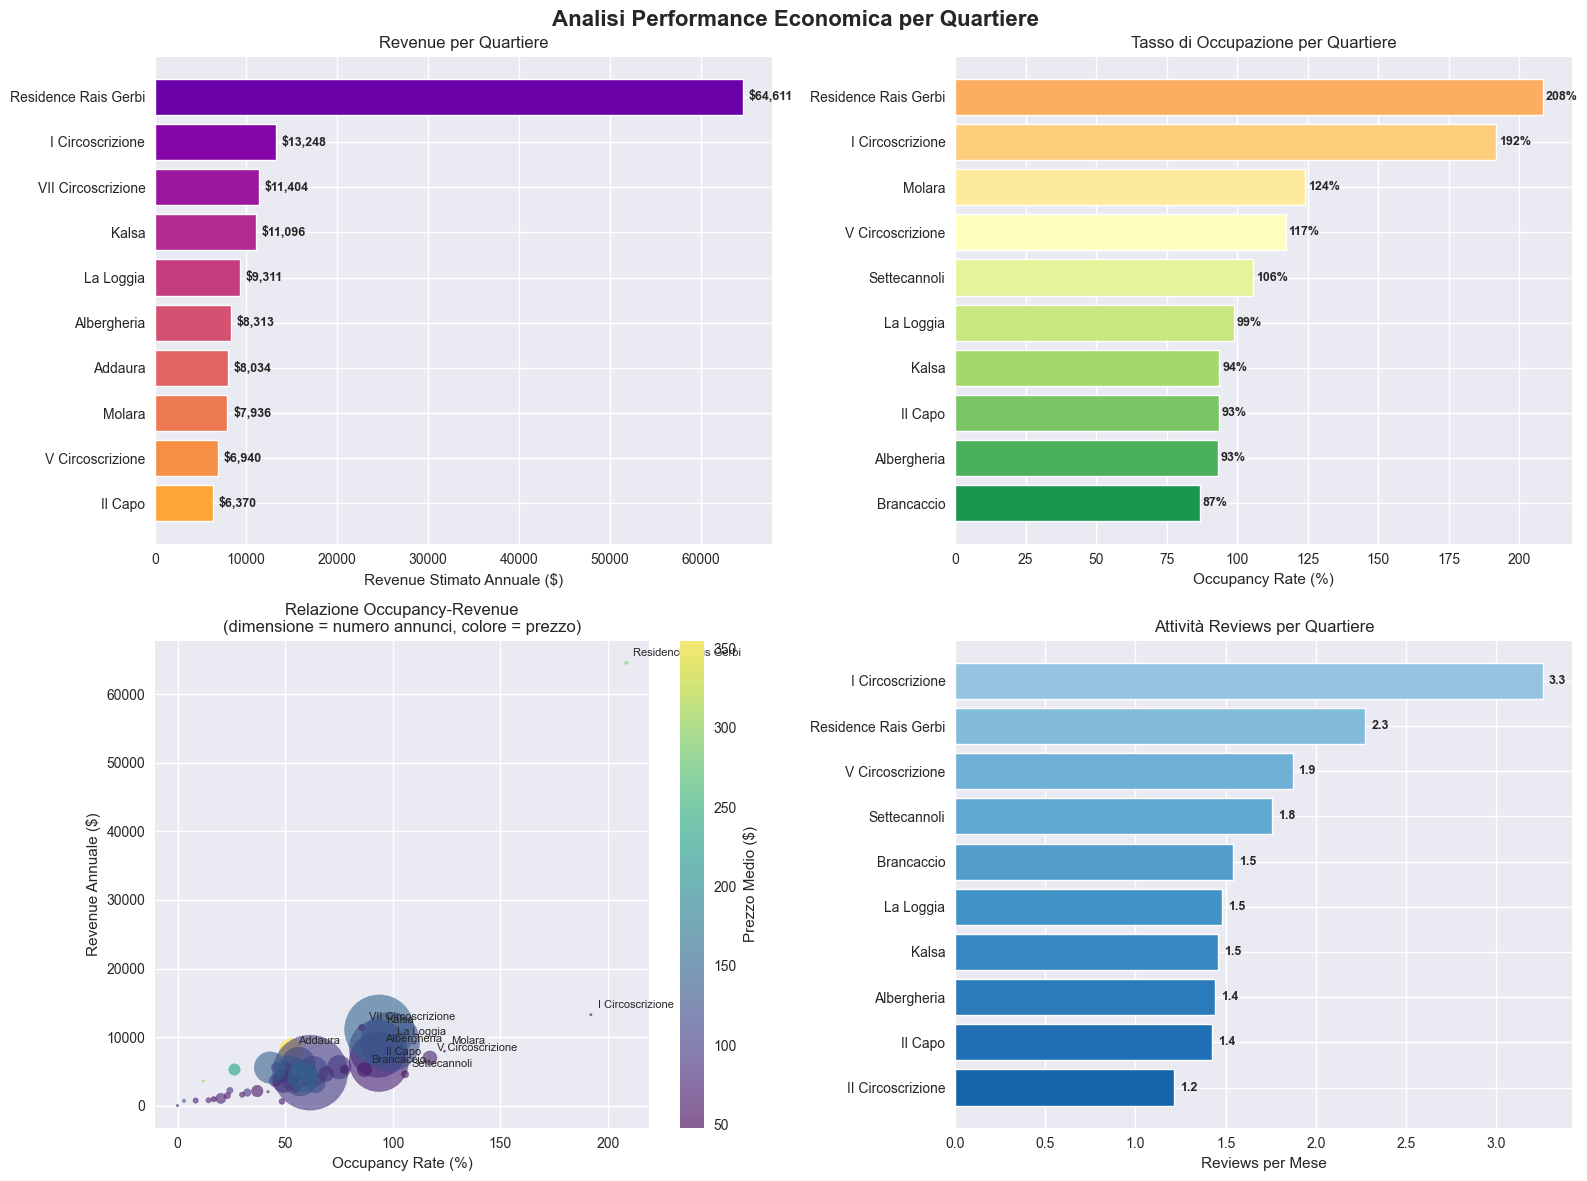


=== ANALISI ROI E PERFORMANCE ===

Quartieri più efficienti (revenue per annuncio):
Residence Rais Gerbi: $32,306 per annuncio
I Circoscrizione: $13,248 per annuncio
Molara: $7,936 per annuncio
Villagrazia: $3,600 per annuncio
Pagliarelli: $2,016 per annuncio

Quartieri HIGH VOLUME: 15 (Addaura, Albergheria, Guadagna)
Quartieri HIGH REVENUE: 15 (Acquasanta, Addaura, Albergheria)
Quartieri VOLUME + REVENUE: 8 (II Circoscrizione, Kalsa, La Loggia, Valdesi, Albergheria, Addaura, Il Capo, Mondello)


C:\Users\andre\AppData\Local\Temp\ipykernel_13660\2187939439.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_clean['revenue_per_listing'] = performance_clean['estimated_revenue_l365d'] / performance_clean['id']


In [33]:
# 4. ANALISI OCCUPANCY RATE E REVENUE PER QUARTIERE
# Metriche chiave per performance economica

# Calcoliamo le metriche di performance per quartiere
performance_by_district = df_price.groupby('district_area').agg({
    'estimated_occupancy_l365d': 'mean',
    'estimated_revenue_l365d': 'mean',
    'reviews_per_month': 'mean',
    'number_of_reviews': 'mean',
    'price_numeric': 'mean',
    'id': 'count'
}).round(2)

# Rimuoviamo i valori nulli e ordiniamo per revenue
performance_clean = performance_by_district.dropna(subset=['estimated_revenue_l365d'])
performance_sorted = performance_clean.sort_values('estimated_revenue_l365d', ascending=False).head(10)

print("Top 10 quartieri per revenue stimato annuale:")
for district, row in performance_sorted.iterrows():
    print(f"{district}: ${row['estimated_revenue_l365d']:,.0f} (occupancy: {row['estimated_occupancy_l365d']:.0f}%)")

# Visualizzazione performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Performance Economica per Quartiere', fontsize=16, fontweight='bold')

# Grafico 1: Revenue per quartiere
colors_revenue = plt.cm.plasma(np.linspace(0.2, 0.8, len(performance_sorted)))
bars = ax1.barh(range(len(performance_sorted)), performance_sorted['estimated_revenue_l365d'], 
                color=colors_revenue, edgecolor='white', linewidth=1)
ax1.set_yticks(range(len(performance_sorted)))
ax1.set_yticklabels(performance_sorted.index, fontsize=10)
ax1.set_xlabel('Revenue Stimato Annuale ($)')
ax1.set_title('Revenue per Quartiere')
ax1.invert_yaxis()

# Aggiungiamo i valori
for i, (bar, value) in enumerate(zip(bars, performance_sorted['estimated_revenue_l365d'])):
    ax1.text(value + max(performance_sorted['estimated_revenue_l365d']) * 0.01, i, 
             f'${value:,.0f}', va='center', ha='left', fontweight='bold', fontsize=9)

# Grafico 2: Occupancy rate per quartiere
occupancy_sorted = performance_clean.sort_values('estimated_occupancy_l365d', ascending=False).head(10)
bars2 = ax2.barh(range(len(occupancy_sorted)), occupancy_sorted['estimated_occupancy_l365d'], 
                 color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(occupancy_sorted))), 
                 edgecolor='white', linewidth=1)
ax2.set_yticks(range(len(occupancy_sorted)))
ax2.set_yticklabels(occupancy_sorted.index, fontsize=10)
ax2.set_xlabel('Occupancy Rate (%)')
ax2.set_title('Tasso di Occupazione per Quartiere')
ax2.invert_yaxis()

# Aggiungiamo i valori
for i, (bar, value) in enumerate(zip(bars2, occupancy_sorted['estimated_occupancy_l365d'])):
    ax2.text(value + 1, i, f'{value:.0f}%', va='center', ha='left', 
             fontweight='bold', fontsize=9)

# Grafico 3: Scatter plot Revenue vs Occupancy
scatter = ax3.scatter(performance_clean['estimated_occupancy_l365d'], 
                     performance_clean['estimated_revenue_l365d'],
                     s=performance_clean['id']*3,  # dimensione = numero annunci
                     alpha=0.6, c=performance_clean['price_numeric'], 
                     cmap='viridis')
ax3.set_xlabel('Occupancy Rate (%)')
ax3.set_ylabel('Revenue Annuale ($)')
ax3.set_title('Relazione Occupancy-Revenue\n(dimensione = numero annunci, colore = prezzo)')

# Colorbar per il prezzo
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Prezzo Medio ($)')

# Etichette per quartieri top performers
for district, row in performance_clean.iterrows():
    if (row['estimated_revenue_l365d'] > performance_clean['estimated_revenue_l365d'].quantile(0.8) or 
        row['estimated_occupancy_l365d'] > performance_clean['estimated_occupancy_l365d'].quantile(0.8)):
        ax3.annotate(district, (row['estimated_occupancy_l365d'], row['estimated_revenue_l365d']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

# Grafico 4: Reviews per month per quartiere
reviews_district = df_price.groupby('district_area')['reviews_per_month'].mean().sort_values(ascending=False).head(10)
bars4 = ax4.barh(range(len(reviews_district)), reviews_district.values, 
                 color=plt.cm.Blues(np.linspace(0.4, 0.8, len(reviews_district))), 
                 edgecolor='white', linewidth=1)
ax4.set_yticks(range(len(reviews_district)))
ax4.set_yticklabels(reviews_district.index, fontsize=10)
ax4.set_xlabel('Reviews per Mese')
ax4.set_title('Attività Reviews per Quartiere')
ax4.invert_yaxis()

# Aggiungiamo i valori
for i, (bar, value) in enumerate(zip(bars4, reviews_district.values)):
    ax4.text(value + max(reviews_district.values) * 0.01, i, f'{value:.1f}', 
             va='center', ha='left', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ROI Analysis
print("\n=== ANALISI ROI E PERFORMANCE ===")
# Calcoliamo una metrica di efficienza: revenue per annuncio
performance_clean['revenue_per_listing'] = performance_clean['estimated_revenue_l365d'] / performance_clean['id']
efficiency_sorted = performance_clean.sort_values('revenue_per_listing', ascending=False)

print("\nQuartieri più efficienti (revenue per annuncio):")
for district, row in efficiency_sorted.head(5).iterrows():
    print(f"{district}: ${row['revenue_per_listing']:,.0f} per annuncio")

# Market saturation vs performance
high_volume = performance_clean[performance_clean['id'] > performance_clean['id'].quantile(0.7)]
high_revenue = performance_clean[performance_clean['estimated_revenue_l365d'] > performance_clean['estimated_revenue_l365d'].quantile(0.7)]

print(f"\nQuartieri HIGH VOLUME: {len(high_volume)} ({', '.join(high_volume.index[:3])})")
print(f"Quartieri HIGH REVENUE: {len(high_revenue)} ({', '.join(high_revenue.index[:3])})")

# Overlap analysis
overlap = set(high_volume.index) & set(high_revenue.index)
print(f"Quartieri VOLUME + REVENUE: {len(overlap)} ({', '.join(overlap)})")

In [ ]:
%pip install scikit-learn

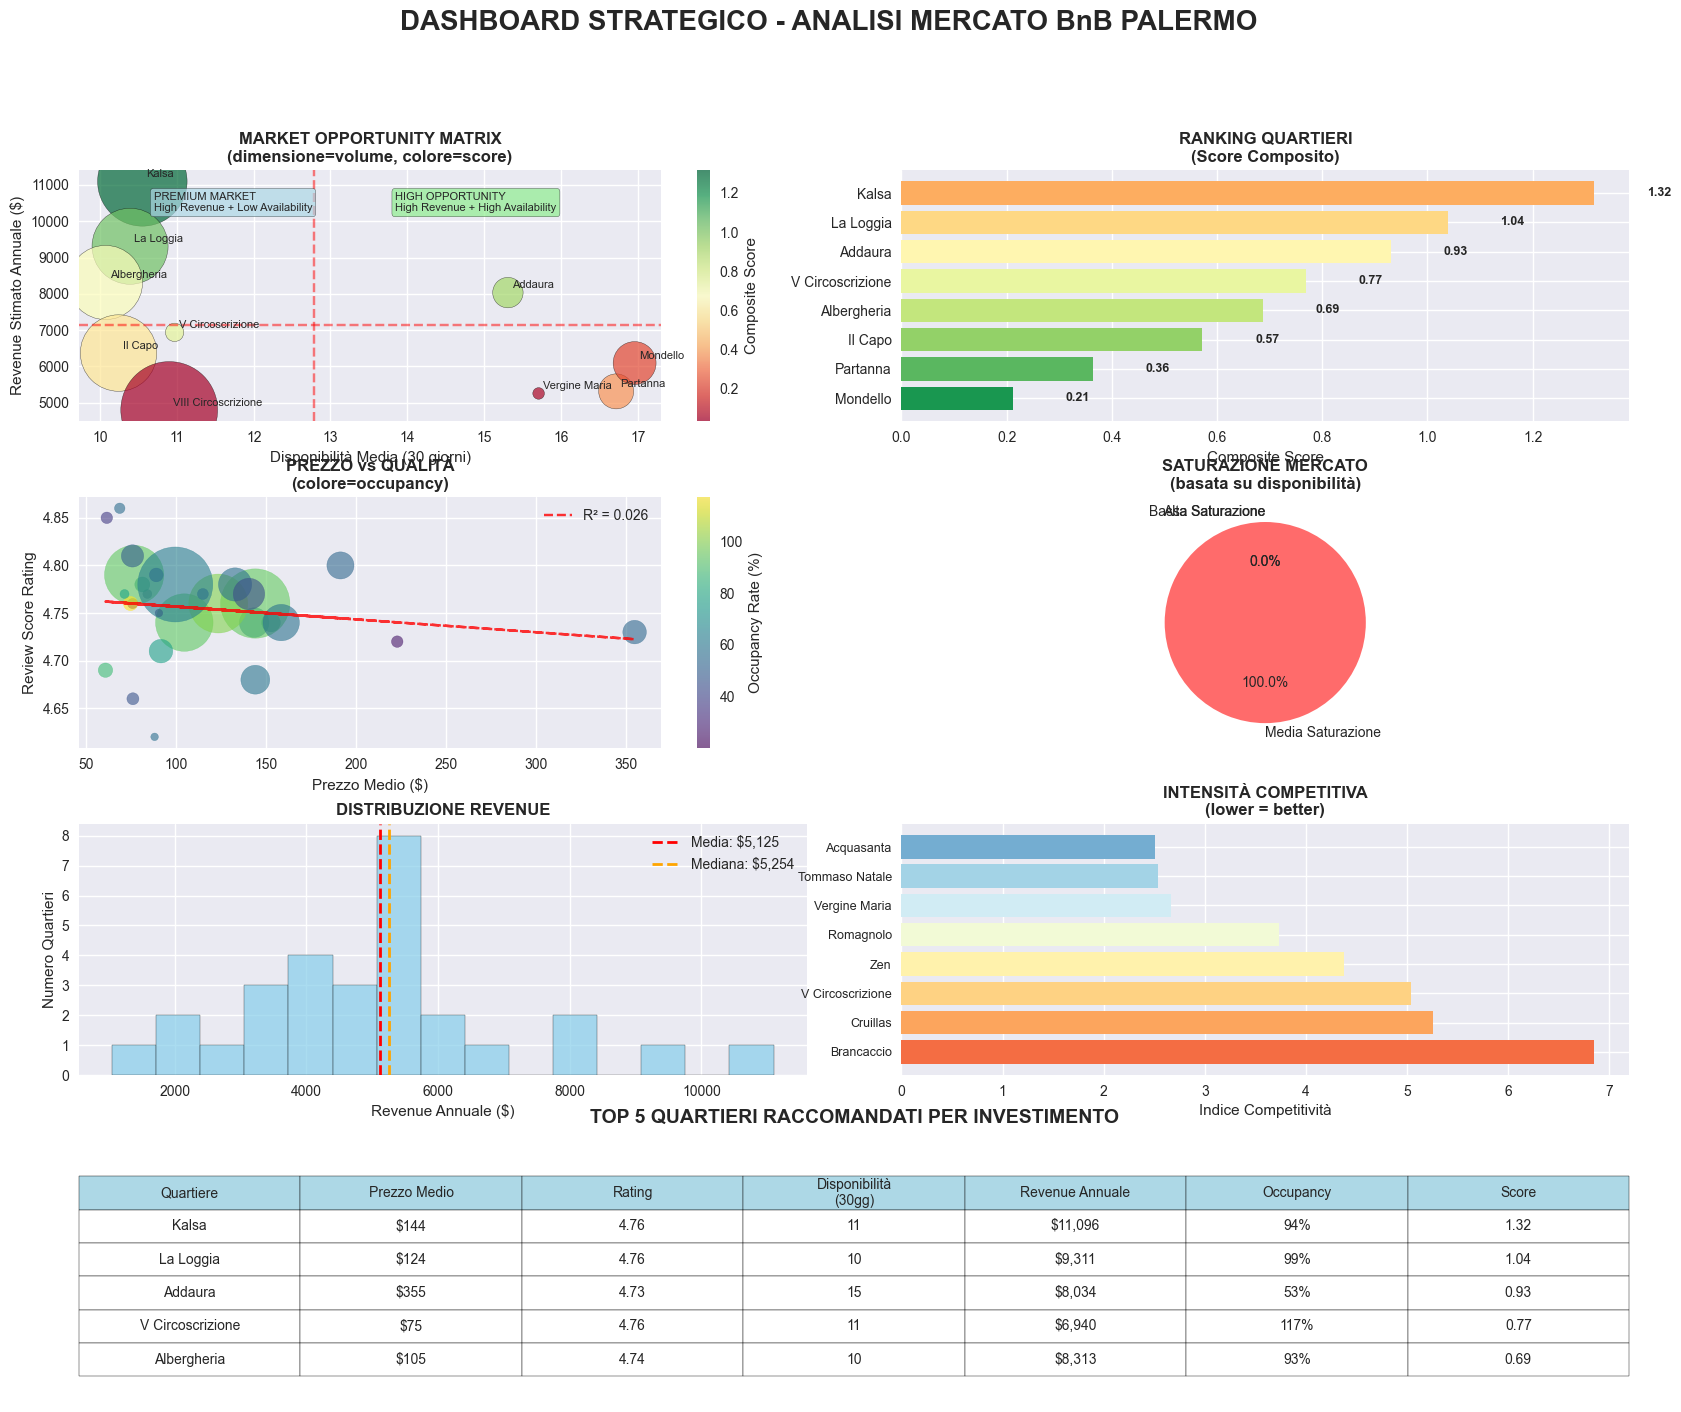


                    EXECUTIVE SUMMARY - MERCATO BnB PALERMO

🎯 TOP 3 QUARTIERI RACCOMANDATI:
   1. Kalsa - Score: 1.32
      💰 Revenue: $11,096 | 📊 Occupancy: 94%
      ⭐ Rating: 4.76 | 📅 Disponibilità: 11 giorni
   2. La Loggia - Score: 1.04
      💰 Revenue: $9,311 | 📊 Occupancy: 99%
      ⭐ Rating: 4.76 | 📅 Disponibilità: 10 giorni
   3. Addaura - Score: 0.93
      💰 Revenue: $8,034 | 📊 Occupancy: 53%
      ⭐ Rating: 4.73 | 📅 Disponibilità: 15 giorni

📈 INSIGHTS CHIAVE:
   • Mercato totale: 5,336 annunci in 29 quartieri
   • Revenue medio: $5,125/anno
   • Prezzo medio: $117/notte
   • Rating medio: 4.75/5.0

🎯 OPPORTUNITÀ DI MERCATO:
   • Quartieri high-opportunity: 6 (Addaura, Mondello, Partanna)
   • Saturazione media del mercato: 16% 

🏆 NICCHIE COMPETITIVE:
   • Quartieri a bassa competizione: 9
   • High revenue + Low competition: 4 (Acquasanta, Romagnolo)

💡 RACCOMANDAZIONI STRATEGICHE:
   1. Focus su Kalsa per massimo ROI
   2. Considera La Loggia per diversificazione
   3. 

In [34]:
# 5. ANALISI COMPETITIVA E SINTESI STRATEGICA
# Dashboard finale per decision making

# Creiamo un dataset completo per l'analisi strategica
strategic_data = df_price.groupby('district_area').agg({
    'id': 'count',  # numero annunci
    'price_numeric': 'mean',  # prezzo medio
    'availability_30': 'mean',  # disponibilità
    'review_scores_rating': 'mean',  # qualità
    'estimated_revenue_l365d': 'mean',  # revenue
    'estimated_occupancy_l365d': 'mean',  # occupancy
    'reviews_per_month': 'mean',  # attività
    'instant_bookable': lambda x: (x == True).mean() * 100  # % instant bookable
}).round(2)

# Rimuoviamo valori nulli e filtriamo quartieri con almeno 10 annunci
strategic_clean = strategic_data[strategic_data['id'] >= 10].dropna()

# Normalizziamo i dati per creare un punteggio composito
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Selezioniamo le metriche chiave per il punteggio
metrics = ['price_numeric', 'review_scores_rating', 'estimated_revenue_l365d', 
           'estimated_occupancy_l365d', 'reviews_per_month']

metrics_data = strategic_clean[metrics].fillna(strategic_clean[metrics].mean())
scaler = StandardScaler()
metrics_normalized = scaler.fit_transform(metrics_data)

# Pesi per le diverse metriche (basati su importanza business)
weights = {
    'price_numeric': 0.2,
    'review_scores_rating': 0.25,
    'estimated_revenue_l365d': 0.3,
    'estimated_occupancy_l365d': 0.15,
    'reviews_per_month': 0.1
}

# Calcoliamo il punteggio composito
composite_score = np.zeros(len(metrics_normalized))
for i, metric in enumerate(metrics):
    composite_score += metrics_normalized[:, i] * weights[metric]

strategic_clean['composite_score'] = composite_score
strategic_ranked = strategic_clean.sort_values('composite_score', ascending=False)

# DASHBOARD STRATEGICO
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Titolo principale
fig.suptitle('DASHBOARD STRATEGICO - ANALISI MERCATO BnB PALERMO', 
             fontsize=20, fontweight='bold', y=0.98)

# 1. Market Opportunity Matrix
ax1 = fig.add_subplot(gs[0, :2])
top_10_strategic = strategic_ranked.head(10)

# Bubble chart: Revenue vs Availability (opportunity)
scatter = ax1.scatter(top_10_strategic['availability_30'], 
                     top_10_strategic['estimated_revenue_l365d'],
                     s=top_10_strategic['id']*5, 
                     c=top_10_strategic['composite_score'], 
                     cmap='RdYlGn', alpha=0.7, edgecolors='black')

ax1.set_xlabel('Disponibilità Media (30 giorni)')
ax1.set_ylabel('Revenue Stimato Annuale ($)')
ax1.set_title('MARKET OPPORTUNITY MATRIX\n(dimensione=volume, colore=score)', fontweight='bold')

# Quadranti strategici
avg_avail = top_10_strategic['availability_30'].mean()
avg_revenue = top_10_strategic['estimated_revenue_l365d'].mean()
ax1.axvline(avg_avail, color='red', linestyle='--', alpha=0.5)
ax1.axhline(avg_revenue, color='red', linestyle='--', alpha=0.5)

# Etichette quadranti
ax1.text(ax1.get_xlim()[1]*0.8, ax1.get_ylim()[1]*0.9, 'HIGH OPPORTUNITY\nHigh Revenue + High Availability', 
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), fontsize=8)
ax1.text(ax1.get_xlim()[0]*1.1, ax1.get_ylim()[1]*0.9, 'PREMIUM MARKET\nHigh Revenue + Low Availability', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), fontsize=8)

# Etichette per i quartieri
for district, row in top_10_strategic.iterrows():
    ax1.annotate(district, (row['availability_30'], row['estimated_revenue_l365d']), 
                xytext=(3, 3), textcoords='offset points', fontsize=8)

cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Composite Score')

# 2. Ranking Quartieri
ax2 = fig.add_subplot(gs[0, 2:])
top_8_districts = strategic_ranked.head(8)
y_pos = np.arange(len(top_8_districts))

bars = ax2.barh(y_pos, top_8_districts['composite_score'], 
                color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_8_districts))))
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_8_districts.index, fontsize=10)
ax2.set_xlabel('Composite Score')
ax2.set_title('RANKING QUARTIERI\n(Score Composito)', fontweight='bold')
ax2.invert_yaxis()

# Aggiungiamo valori
for i, (bar, value) in enumerate(zip(bars, top_8_districts['composite_score'])):
    ax2.text(value + 0.1, i, f'{value:.2f}', va='center', ha='left', 
             fontweight='bold', fontsize=9)

# 3. Analisi Prezzo vs Qualità
ax3 = fig.add_subplot(gs[1, :2])
scatter3 = ax3.scatter(strategic_clean['price_numeric'], 
                      strategic_clean['review_scores_rating'],
                      s=strategic_clean['id']*3, 
                      c=strategic_clean['estimated_occupancy_l365d'], 
                      cmap='viridis', alpha=0.6)
ax3.set_xlabel('Prezzo Medio ($)')
ax3.set_ylabel('Review Score Rating')
ax3.set_title('PREZZO vs QUALITÀ\n(colore=occupancy)', fontweight='bold')

# Linea di tendenza
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    strategic_clean['price_numeric'], strategic_clean['review_scores_rating'])
line = slope * strategic_clean['price_numeric'] + intercept
ax3.plot(strategic_clean['price_numeric'], line, 'r--', alpha=0.8, 
         label=f'R² = {r_value**2:.3f}')
ax3.legend()

cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Occupancy Rate (%)')

# 4. Market Saturation Analysis
ax4 = fig.add_subplot(gs[1, 2:])

# Creiamo categorie di saturazione
strategic_clean['saturation'] = pd.cut(strategic_clean['availability_30'], 
                                      bins=[0, 10, 20, 30], 
                                      labels=['Alta Saturazione', 'Media Saturazione', 'Bassa Saturazione'])

saturation_counts = strategic_clean['saturation'].value_counts()
pie = ax4.pie(saturation_counts.values, labels=saturation_counts.index, 
              autopct='%1.1f%%', startangle=90, 
              colors=['#FF6B6B', '#FFE66D', '#4ECDC4'])
ax4.set_title('SATURAZIONE MERCATO\n(basata su disponibilità)', fontweight='bold')

# 5. Revenue Distribution
ax5 = fig.add_subplot(gs[2, :2])
revenue_data = strategic_clean['estimated_revenue_l365d'].dropna()
ax5.hist(revenue_data, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
ax5.axvline(revenue_data.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Media: ${revenue_data.mean():,.0f}')
ax5.axvline(revenue_data.median(), color='orange', linestyle='--', linewidth=2,
           label=f'Mediana: ${revenue_data.median():,.0f}')
ax5.set_xlabel('Revenue Annuale ($)')
ax5.set_ylabel('Numero Quartieri')
ax5.set_title('DISTRIBUZIONE REVENUE', fontweight='bold')
ax5.legend()

# 6. Competitive Intensity
ax6 = fig.add_subplot(gs[2, 2:])
competitive_data = strategic_clean.copy()
competitive_data['competitive_intensity'] = competitive_data['id'] / competitive_data['estimated_revenue_l365d'] * 1000
comp_sorted = competitive_data.sort_values('competitive_intensity', ascending=True).head(8)

bars6 = ax6.barh(range(len(comp_sorted)), comp_sorted['competitive_intensity'], 
                 color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(comp_sorted))))
ax6.set_yticks(range(len(comp_sorted)))
ax6.set_yticklabels(comp_sorted.index, fontsize=9)
ax6.set_xlabel('Indice Competitività')
ax6.set_title('INTENSITÀ COMPETITIVA\n(lower = better)', fontweight='bold')
ax6.invert_yaxis()

# 7. Summary Table - Top 5 Recommendations
ax7 = fig.add_subplot(gs[3, :])
ax7.axis('tight')
ax7.axis('off')

# Prepariamo i dati per la tabella riassuntiva
top_5_recommendations = strategic_ranked.head(5)
table_data = []
for district, row in top_5_recommendations.iterrows():
    table_data.append([
        district,
        f"${row['price_numeric']:.0f}",
        f"{row['review_scores_rating']:.2f}",
        f"{row['availability_30']:.0f}",
        f"${row['estimated_revenue_l365d']:,.0f}",
        f"{row['estimated_occupancy_l365d']:.0f}%",
        f"{row['composite_score']:.2f}"
    ])

columns = ['Quartiere', 'Prezzo Medio', 'Rating', 'Disponibilità\n(30gg)', 
           'Revenue Annuale', 'Occupancy', 'Score']

table = ax7.table(cellText=table_data, colLabels=columns, 
                  cellLoc='center', loc='center',
                  colColours=['lightblue']*len(columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

ax7.set_title('TOP 5 QUARTIERI RACCOMANDATI PER INVESTIMENTO', 
              fontweight='bold', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# EXECUTIVE SUMMARY
print("\n" + "="*80)
print("                    EXECUTIVE SUMMARY - MERCATO BnB PALERMO")
print("="*80)

print(f"\n🎯 TOP 3 QUARTIERI RACCOMANDATI:")
for i, (district, row) in enumerate(strategic_ranked.head(3).iterrows(), 1):
    print(f"   {i}. {district} - Score: {row['composite_score']:.2f}")
    print(f"      💰 Revenue: ${row['estimated_revenue_l365d']:,.0f} | 📊 Occupancy: {row['estimated_occupancy_l365d']:.0f}%")
    print(f"      ⭐ Rating: {row['review_scores_rating']:.2f} | 📅 Disponibilità: {row['availability_30']:.0f} giorni")

print(f"\n📈 INSIGHTS CHIAVE:")
print(f"   • Mercato totale: {len(df_clean):,} annunci in {len(strategic_clean)} quartieri")
print(f"   • Revenue medio: ${strategic_clean['estimated_revenue_l365d'].mean():,.0f}/anno")
print(f"   • Prezzo medio: ${strategic_clean['price_numeric'].mean():.0f}/notte")
print(f"   • Rating medio: {strategic_clean['review_scores_rating'].mean():.2f}/5.0")

# Market Opportunities
high_avail_high_revenue = strategic_clean[
    (strategic_clean['availability_30'] > strategic_clean['availability_30'].median()) &
    (strategic_clean['estimated_revenue_l365d'] > strategic_clean['estimated_revenue_l365d'].median())
]

print(f"\n🎯 OPPORTUNITÀ DI MERCATO:")
print(f"   • Quartieri high-opportunity: {len(high_avail_high_revenue)} ({', '.join(high_avail_high_revenue.index[:3])})")
print(f"   • Saturazione media del mercato: {(30 - strategic_clean['availability_30'].mean()):.0f}% ")

# Competitive landscape
low_competition = strategic_clean[strategic_clean['id'] < strategic_clean['id'].quantile(0.3)]
high_revenue_low_comp = low_competition[low_competition['estimated_revenue_l365d'] > low_competition['estimated_revenue_l365d'].median()]

print(f"\n🏆 NICCHIE COMPETITIVE:")
print(f"   • Quartieri a bassa competizione: {len(low_competition)}")
print(f"   • High revenue + Low competition: {len(high_revenue_low_comp)} ({', '.join(high_revenue_low_comp.index[:2])})")

print(f"\n💡 RACCOMANDAZIONI STRATEGICHE:")
print(f"   1. Focus su {strategic_ranked.index[0]} per massimo ROI")
print(f"   2. Considera {strategic_ranked.index[1]} per diversificazione")
print(f"   3. Monitora {strategic_ranked.index[2]} per espansione futura")
print(f"   4. Evita quartieri over-saturated con <10 giorni disponibilità")
print(f"   5. Punta su qualità (rating >4.8) per differenziazione")

print("\n" + "="*80)

## 📊 CONCLUSIONI E NEXT STEPS PER L'APP BnB TRACKING

### Insights Chiave per lo Sviluppo dell'App:

1. **Market Opportunity Identification**
   - I quartieri con alta disponibilità e alto revenue rappresentano le migliori opportunità
   - Focus su metriche composite per ranking automatico

2. **Competitive Intelligence Features**
   - Sistema di alert per cambiamenti di prezzo per quartiere
   - Monitoring della saturazione del mercato in tempo reale
   - Benchmark di performance vs competitors

3. **Revenue Optimization**
   - Algoritmi di pricing dinamico basati su quartiere e stagionalità
   - Previsioni di occupancy per ottimizzazione calendario
   - Analytics predittive per ROI

4. **Quality Monitoring**
   - Dashboard review scores per quartiere
   - Alert per cali di qualità
   - Best practices per miglioramento rating

### Features Raccomandate per l'App:

✅ **Dashboard Real-time** con metriche per quartiere  
✅ **Heat Map** interattiva di Palermo con performance overlay  
✅ **Competitor Analysis** con pricing e availability tracking  
✅ **Predictive Analytics** per revenue forecasting  
✅ **Alert System** per opportunità di mercato  
✅ **ROI Calculator** per nuovi investimenti  

### Target Users dell'App:
- **Property Managers**: Ottimizzazione portfolio esistente
- **Investitori**: Identificazione nuove opportunità  
- **Host individuali**: Benchmarking e pricing optimization
- **Agenziе immobiliari**: Market intelligence per clienti